In [3]:
from src import *
import scipy
from scipy.cluster.hierarchy import fclusterdata
from tqdm.auto import tqdm

0.05305164769729845
1/D_R*beta: 75.88388052149259


### Export

In [4]:
def save_output(time, Rs_sol, ps_sol, N, Omega, custom_name = "name", skip = 10, num = 50000):
    if custom_name == "name":
        f = open(f"outputOmega{Omega}N{N}.txt", "w")
    else:
        f = open(f"{custom_name}.txt", "w")
    for i in range(0, num, skip):
        f.write("ITEM: TIMESTEP"+ '\n')
        f.write(str(time[i])+ '\n')
        f.write("ITEM: NUMBER OF ATOMS"+ '\n'), 
        f.write(str(N)+ '\n')
        f.write("ITEM: ATOMS id x y z vx vy vz"+ '\n')
        for j in range(N):
            s = ''
            s += str(j)
            for k in range(3):
                s += ' '
                s += str(Rs_sol[i, j, k])
            #s += ' 0'
            for k in range(3):
                s += ' '
                s += str(ps_sol[i, j, k])
            f.write(s+ '\n')
    f.close()        
    

### Import

In [5]:
def load_output(filename):
    times = []
    Rs_list = []
    ps_list = []

    with open(filename, "r") as f:
        while True:
            line = f.readline()
            if not line:
                break  # EOF

            if line.startswith("ITEM: TIMESTEP"):
                # timestep
                t = float(f.readline().strip())
                times.append(t)

                # number of atoms
                f.readline()  # "ITEM: NUMBER OF ATOMS"
                N = int(f.readline().strip())

                # header
                f.readline()  # "ITEM: ATOMS id x y z vx vy vz"

                R_block = np.zeros((N, 3))
                p_block = np.zeros((N, 3))

                for i in range(N):
                    parts = f.readline().strip().split()
                    idx = int(parts[0])  # atom id
                    R_block[idx] = [float(x) for x in parts[1:4]]
                    p_block[idx] = [float(x) for x in parts[4:7]]

                Rs_list.append(R_block)
                ps_list.append(p_block)

    # convert lists to numpy arrays
    times = np.array(times)
    Rs_sol = np.array(Rs_list)  # shape (timesteps, N, 3)
    ps_sol = np.array(ps_list)  # shape (timesteps, N, 3)

    return times, Rs_sol, ps_sol



### Plotting

In [6]:
def plot_function(coordinates, values, grid_size=100, custom_name = "Average value"):
    """
    Plot the average function value over the coordinates on a 2D plot.

    Parameters:
        coordinates (list of tuples): List of (x, y) coordinates.
        values (list of floats): Function values corresponding to each coordinate.
        grid_size (int): Number of grid points in each dimension for averaging.
    """
    # Convert input to numpy arrays
    coordinates = np.array(coordinates)
    values = np.array(values)

    # Create a grid for averaging
    x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
    y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Initialize grid for averaged values
    avg_values = np.zeros_like(xx)
    count = np.zeros_like(xx)

    # Compute the average values for each grid cell
    for (x, y), value in zip(coordinates, values):
        i = np.searchsorted(x_grid, x) - 1
        j = np.searchsorted(y_grid, y) - 1

        if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
            avg_values[j, i] += value
            count[j, i] += 1

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_values = np.divide(avg_values, count, out=np.zeros_like(avg_values), where=count > 0)

    # Plot the results
    plt.figure(figsize=(8, 6))
    #plt.contourf(xx, yy, avg_values, levels=50, cmap='jet')
    plt.pcolormesh(xx, yy, avg_values, cmap='viridis')
    plt.colorbar(label=custom_name)
    #plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, edgecolor='k', cmap='viridis', label="Data Points")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(custom_name)
    #plt.legend()
    angle = np.linspace(-np.pi, np.pi, 100)
    plt.plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
    plt.plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
    plt.axis('equal')
    plt.show()


In [7]:
def plot_density(R, Omegas, depletion = False):
    fig, axs = plt.subplots(2, 5, figsize = (15,6))
    for i in range(len(Omegas)):
        steady = R[i][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        r = np.linalg.norm(coords[:, :2], axis = 1)
        axs[i // 5, i % 5].hist2d(coords[:, 0], coords[:, 1], bins = 40, range = [[-R2, R2], [-R2, R2]])
        axs[i // 5, i % 5].axis('equal')
        if i//5 != 0:
            axs[i // 5, i % 5].set_xlabel('x')
        axs[i // 5, i % 5].set_ylabel('y')
        axs[i // 5, i % 5].set_title(r'$\Omega = $'+f'{Omegas[i]:.2f}')   
        angle = np.linspace(-np.pi, np.pi, 100)
        axs[i // 5, i % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs[i // 5, i % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        if depletion:
            R_dep = scipy.optimize.fsolve(V, R1, args = Omegas[i], xtol=1e-06, maxfev=500)
            axs[i // 5, i % 5].plot(R_dep[0] * np.cos(angle), R_dep[0] * np.sin(angle), color = 'red')
        approx_R = get_params(Omegas[i])[1] / v0
        #axs[i // 5, i % 5].plot(approx_R * np.cos(angle), approx_R * np.sin(angle), color = 'red')
    fig.suptitle('density')
    plt.show()

In [65]:
def plot_velocity(R, Omegas, dt = 0.1, grid_size=50):
    
    fig1, axs1 = plt.subplots(2, 5, figsize = (17,7))
    fig2, axs2 = plt.subplots(2, 5, figsize = (17,7))
    for l in range(len(Omegas)):
        steady = R[l][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        coords = coords[:,:2]
        steady1 = R[l][-40001:-2:100, :, :]
        vs = (steady - steady1) / dt
        vs = vs.reshape((40000,3))
        
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        alpha = np.arctan2(vs[:, 1], vs[:, 0])
        r = np.linalg.norm(coords[:, :2], axis = 1)
        v = np.linalg.norm(vs[:, :2], axis = 1)
        v_r = v * np.cos(psi - alpha)
        v_phi = v * np.sin(psi - alpha)
        

        # Create a grid for averaging
        x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
        y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
        x_grid = np.linspace(x_min, x_max, grid_size)
        y_grid = np.linspace(y_min, y_max, grid_size)
        xx, yy = np.meshgrid(x_grid, y_grid)

        # Initialize grid for averaged values of v_phi
        avg_v_phi = np.zeros_like(xx)
        count = np.zeros_like(xx)

        # Compute the average values for each grid cell
        for (x, y), value in zip(coords, v_phi):
            i = np.searchsorted(x_grid, x) - 1
            j = np.searchsorted(y_grid, y) - 1

            if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
                avg_v_phi[j, i] += value
                count[j, i] += 1

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            avg_v_phi = np.divide(avg_v_phi, count, out=np.zeros_like(avg_v_phi), where=count > 0)

        # Initialize grid for averaged values of v_r
        avg_v_r = np.zeros_like(xx)
        count = np.zeros_like(xx)

        # Compute the average values for each grid cell
        for (x, y), value in zip(coords, v_r):
            i = np.searchsorted(x_grid, x) - 1
            j = np.searchsorted(y_grid, y) - 1

            if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
                avg_v_r[j, i] += value
                count[j, i] += 1

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            avg_v_r = np.divide(avg_v_r, count, out=np.zeros_like(avg_v_r), where=count > 0)

        # Plot the results
        pcm = axs1[l // 5, l % 5].pcolormesh(xx, yy, avg_v_phi, cmap='viridis')
        fig1.colorbar(pcm, ax =  axs1[l // 5, l % 5])
        axs1[l // 5, l % 5].set_xlabel("x")
        axs1[l // 5, l % 5].set_ylabel("y")
        axs1[l // 5, l % 5].set_title(f'{Omegas[l]:.2f}')
        angle = np.linspace(-np.pi, np.pi, 100)
        axs1[l // 5, l % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs1[l // 5, l % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        axs1[l // 5, l % 5].axis('equal')

        pcm = axs2[l // 5, l % 5].pcolormesh(xx, yy, avg_v_r, cmap='viridis')
        fig2.colorbar(pcm, ax =  axs2[l // 5, l % 5])
        axs2[l // 5, l % 5].set_xlabel("x")
        axs2[l // 5, l % 5].set_ylabel("y")
        axs2[l // 5, l % 5].set_title(f'{Omegas[l]:.2f}')
        angle = np.linspace(-np.pi, np.pi, 100)
        axs2[l // 5, l % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs2[l // 5, l % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        axs2[l // 5, l % 5].axis('equal')
  
    fig1.suptitle('v_phi')
    fig2.suptitle('v_r')
    plt.show()


In [8]:
def plot_delta(R, p, Omegas):
    deltas = []
    for i in range(len(Omegas)):
        steady = R[i][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        steady_p = p[i][-40000:-1:100, :, :]
        coords_p = steady_p.reshape((40000,3))
        phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
        delta = psi - phi
        deltas.append(np.mean(delta))
    plt.plot(Omegas, deltas)
    plt.xlabel("Omega")
    plt.ylabel("delta")
    plt.show()

In [9]:
def V(R, Omega):
    B = Omega * R2 ** 2 / (R2 ** 2 / R1 ** 2 - 1)
    return(0.5  * (B ** 2/ R ** 2 * (np.log(R2/R) - v0/B * R2) ** 2 - v0 ** 2))

In [10]:
def plot_seeds_average(epsilon, omega, N=25):

    fig, axs = plt.subplots(1, 2, figsize = (12,5), layout = 'constrained')
    av_sizes = []
    max_sizes = []
    for i in tqdm(range(N)):
        times, Rs, ps = load_output(f"{omega:.1f}o_{epsilon}e/id{i}.txt")
        av_sizes.append(get_av_cluster_size(Rs))
        max_sizes.append(get_max_cluster_size(Rs))
        #print(f'done for id{i}')
    av_sizes = np.array(av_sizes)
    max_sizes = np.array(max_sizes)
    av_mean = np.mean(av_sizes, axis=0)
    av_std = np.std(av_sizes, axis=0)
    max_mean = np.mean(max_sizes, axis=0)
    max_std = np.std(max_sizes, axis=0)
    
    axs[0].plot(times[::10], av_mean, linestyle='-', color='blue')
    axs[0].fill_between(times[::10], av_mean - av_std, av_mean + av_std, alpha=0.3, color='blue', label='±1σ')
    axs[0].set_title('Average cluster size') 
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Size')
    axs[0].grid(True)
    
    axs[1].plot(times[::10], max_mean, linestyle='-', color='blue')
    axs[1].fill_between(times[::10], max_mean - max_std, max_mean + max_std, alpha=0.3, color='blue', label='±1σ')
    axs[1].set_title('Maximum cluster size') 
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Size')
    axs[1].grid(True)
    
    title = r'$\varepsilon = $'f'{epsilon} $\Omega = $'f'{omega:.1f}'
    fig.suptitle(title)
    
    plt.tight_layout()
    plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\O'
<>:32: SyntaxWarning: invalid escape sequence '\O'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_78357/185031110.py:32: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{epsilon} $\Omega = $'f'{omega:.1f}'


### Test run

In [37]:
N = 100
zs = np.random.uniform(0, L, N)
psis = np.random.uniform(0, 2*np.pi, N)
Rs = np.random.triangular(R1 + R, R2 - R, R2 - R, N)
vecs = np.random.normal(size = (N, 3))
R0s = []
p0s = []
kx = np.array([1, 0, 0]) # up vector
k0 = np.array([0, 0, 0]) 
for i in range(N):
    R0s.append([Rs[i] * np.cos(psis[i]), Rs[i] * np.sin(psis[i]), zs[i]])
    p0s.append(vecs[i]/np.linalg.norm(vecs[i]))

In [9]:
ps_sol, Rs_sol, t = solver(0.1, 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

No tumbling
omega/D_R: 30.660153746057613


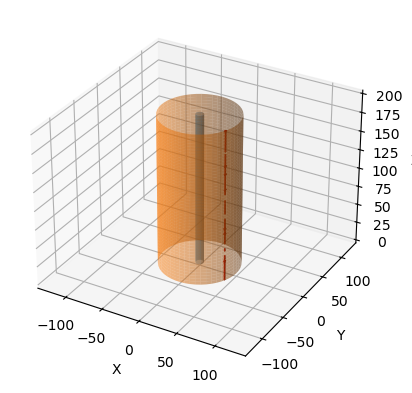

In [10]:
plot_state(Rs_sol[-1, :, :])

In [11]:
pss, Rss, t = solver(5, 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [12]:
save_output(t, Rss, pss, N, 5)

In [13]:
steady = Rss[-40000:-1:100, :, :]
coords = steady.reshape((40000,3))
psi = np.arctan2(coords[:, 1], coords[:, 0])
r = np.linalg.norm(coords[:, :2], axis = 1)

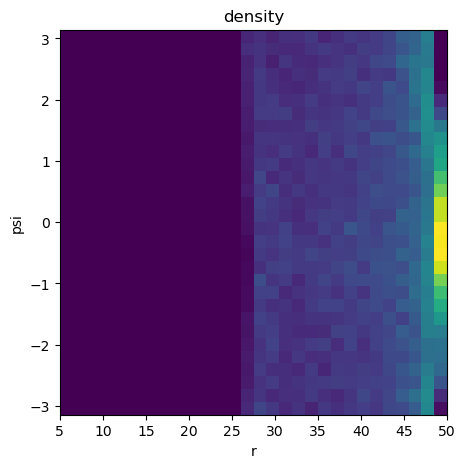

In [14]:
fig, axs = plt.subplots(figsize = (5,5))
axs.hist2d(r, psi, bins = 30, range = [[R1, R2], [-np.pi, np.pi]])
axs.set_xlabel('r')
axs.set_ylabel('psi')
axs.set_title('density')
plt.show()

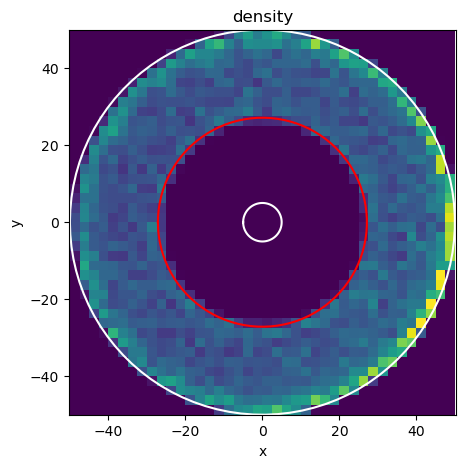

In [17]:
fig, axs = plt.subplots(figsize = (5,5))
axs.hist2d(coords[:, 0], coords[:, 1], bins = 40, range = [[-R2, R2], [-R2, R2]])
axs.axis('equal')
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title('density')

R_dep = scipy.optimize.fsolve(V, R1, args = 5, xtol=1e-06, maxfev=500)
angle = np.linspace(-np.pi, np.pi, 100)
axs.plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
axs.plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
axs.plot(R_dep[0] * np.cos(angle), R_dep[0] * np.sin(angle), color = 'red')
#plt.colorbar()
plt.show()

In [18]:
steady = Rss[-40000:-1:100, :, :]
coords = steady.reshape((40000,3))
#coords = Rss[-1, :, :]
#vs = (Rss[-1, :, :] - Rss[-2, :, :]) / 0.1
steady1 = Rss[-40001:-2:100, :, :]
vs = (steady - steady1) / 0.1
vs = vs.reshape((40000,3))
psi = np.arctan2(coords[:, 1], coords[:, 0])
alpha = np.arctan2(vs[:, 1], vs[:, 0])
r = np.linalg.norm(coords[:, :2], axis = 1)
v = np.linalg.norm(vs[:, :2], axis = 1)
v_r = v * np.cos(psi - alpha)
v_phi = v * np.sin(psi - alpha)

In [19]:
steady_p = pss[-40000:-1:100, :, :]
coords_p = steady.reshape((40000,3))
phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
delta = psi-phi

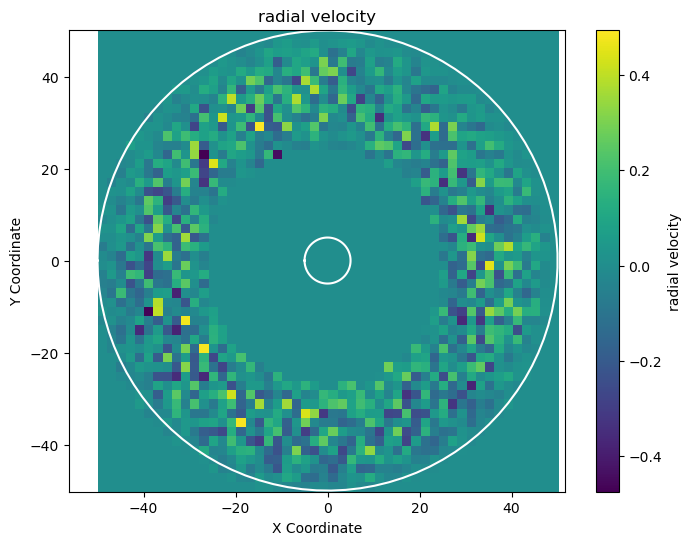

In [20]:
plot_function(coords[:,:2], v_r, grid_size = 50, custom_name = "radial velocity")

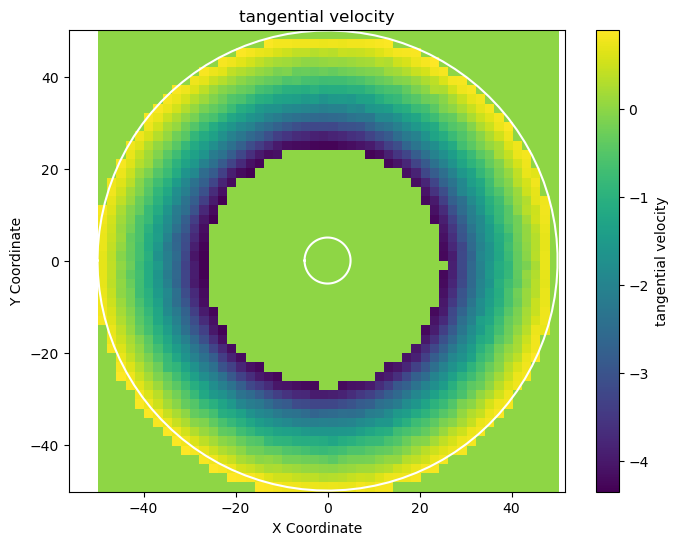

In [21]:
plot_function(coords[:,:2], v_phi, grid_size = 50, custom_name = "tangential velocity")

In [22]:
ps1, Rs1, t = solver(0.5, 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

Tumbling period: 1431.7881813614306
omega/D_R: 153.30076873028807


In [112]:


steady1 = Rs1[-40000:-1:100, :, :]
coords1 = steady1.reshape((40000,3))
psi = np.arctan2(coords1[:, 1], coords1[:, 0])
steady_p = ps1[-40000:-1:100, :, :]
coords_p = steady_p.reshape((40000,3))
phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
delta = (psi-phi)%(2*np.pi)


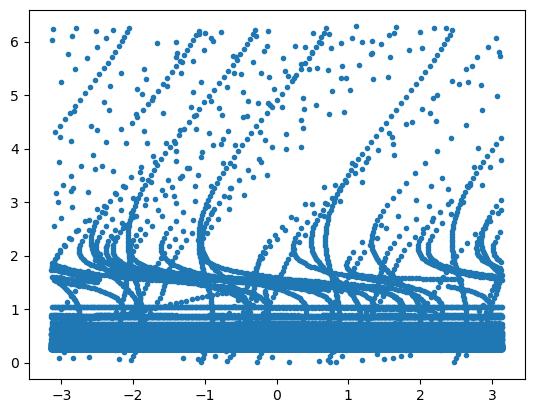

In [113]:
plt.plot(psi, delta, '.')

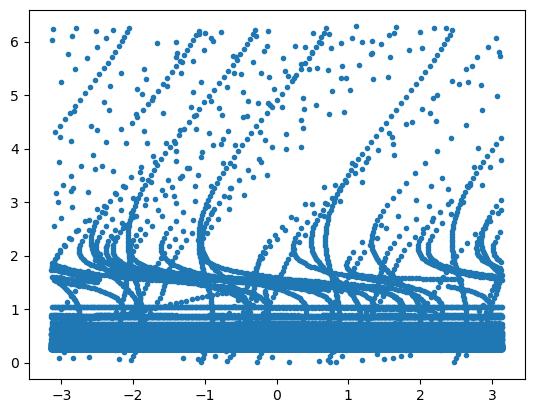

In [114]:
plt.plot(psi, delta, '.')

In [115]:
ps2, Rs2, t = solver(0.2, 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

No tumbling
omega/D_R: 61.32030749211523


In [116]:
save_output(t, Rs2, ps2, N, 0.2, custom_name = "Omega0.2")

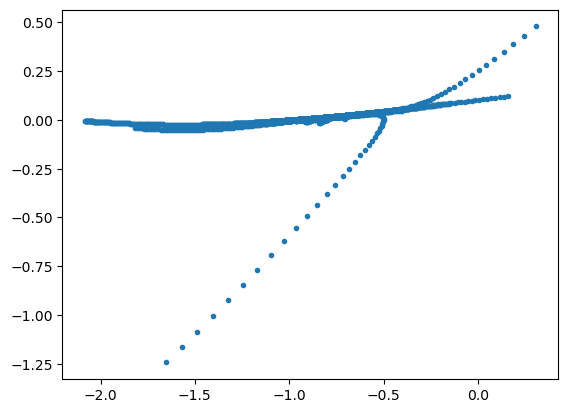

In [117]:

steady2 = Rs2[-40000:-1:100, :, :]
coords2 = steady2.reshape((40000,3))
psi2 = np.arctan2(coords2[:, 1], coords2[:, 0])
steady_p2 = ps2[-40000:-1:100, :, :]
coords_p2 = steady_p2.reshape((40000,3))
phi2 = np.arctan2(coords_p2[:, 1], coords_p2[:, 0])
delta2 = (psi2-phi2)
plt.plot(psi2, delta2, '.')

### Test run high epsilon

In [23]:
pss_e, Rss_e, t = solver(3, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = False)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [119]:
save_output(t, Rss_e, pss_e, N, 5, custom_name="epsilon10", skip = 100, num = 100000)

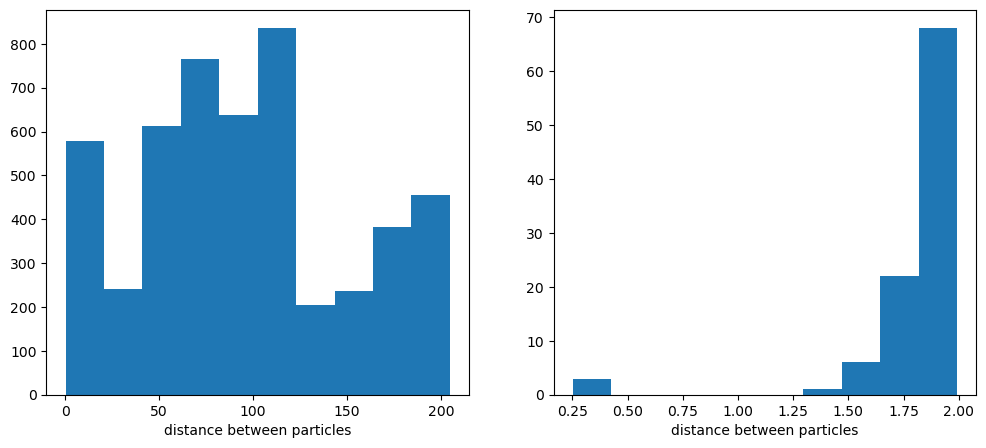

In [145]:
plot_dist(Rss_e, N, 2, 10)

In [14]:
from scipy.cluster.hierarchy import fclusterdata
clust = np.sort(fclusterdata(Rss_e[-1, :, :], t=3, criterion='distance'))
num = clust[-1]
print(clust)

NameError: name 'Rss_e' is not defined

In [30]:
clust_num = 0
for i in range(0, 100, 10):
    clust = np.sort(fclusterdata(Rss_e[-1 - i, :, :], t=3, criterion='distance'))
    clust_num += clust[-1]
clust_num = clust_num // 10
print(clust_num)

61


In [15]:
from collections import Counter 
 
def max_repetitions(sequence): 
    # Count the occurrences of each element 
    counts = Counter(sequence) 
    # Get the maximum count 
    max_count = max(counts.values()) 
    return max_count 

def average_size(sequence):
    counts = Counter(sequence)
    return sum(counts.values()) / len(counts.values())
# Example usage 
sequence = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4] 
result = max_repetitions(sequence) 
print(f"The maximum number of repetitions is: {result}") 

The maximum number of repetitions is: 4


In [165]:
average_size(sequence)

2.5

In [177]:
seq = ['a', 'a', 'b', 'c', 'c', 'c']
counts = Counter(seq)
[*counts.values()]

[2, 1, 3]

In [69]:
def size_distribution(sequence):
    counts = Counter(sequence)
    return [*counts.values()]

In [179]:
size_distribution(sequence)

[1, 2, 3, 4]

In [124]:
average_size(clust)

1.5151515151515151

In [125]:
max_repetitions(clust) 

12

In [16]:
def get_size_distribution(Rs):
    clust = np.sort(fclusterdata(Rs, t=2, criterion='distance'))
    return size_distribution(clust)

In [71]:
pss_e, Rss_e, t = solver(3, 100, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


(array([44.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ,
        19.7, 21.4, 23.1, 24.8, 26.5, 28.2, 29.9, 31.6, 33.3, 35. ]),
 <BarContainer object of 20 artists>)

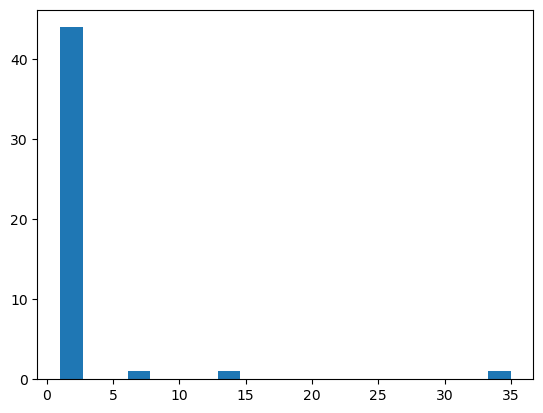

In [73]:
plt.hist(get_size_distribution(Rss_e[-1,:,:]), bins=20)

In [ ]:
save_output(t, Rss_e, pss_e, N, 5, custom_name="epsilon100", skip = 100, num = 100000)

In [26]:
ps_e50, Rs_e50, t50 = solver(3, 50, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [33]:
def get_av_cluster_size(Rs):
    sizes = []
    for i in range(0, len(Rs), 10):
        clust = np.sort(fclusterdata(Rs[i, :, :], t=2, criterion='distance'))
        sizes.append(average_size(clust))
    return sizes

In [17]:
def get_max_cluster_size(Rs):
    sizes = []
    for i in range(0, len(Rs), 10):
        clust = np.sort(fclusterdata(Rs[i, :, :], t=2, criterion='distance'))
        sizes.append(max_repetitions(clust))
    return sizes

In [49]:
sizes = get_av_cluster_size(Rs_e50)

In [52]:
max_sizes = get_max_cluster_size(Rs_e50)

In [60]:
plt.plot(t50[::10], max_sizes)

NameError: name 't50' is not defined

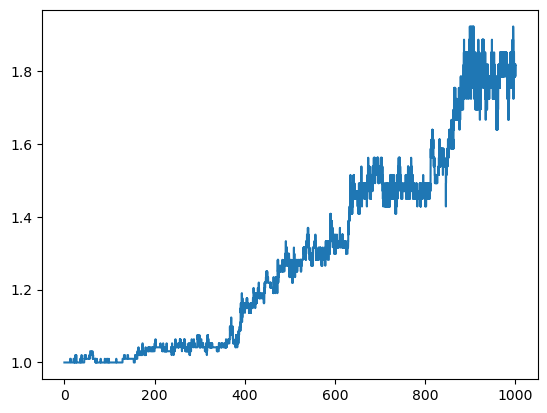

In [50]:
plt.plot(t50[::10], sizes)

In [132]:
window_size = 20
moving_avg = np.convolve(sizes, np.ones(window_size)/window_size, mode='same')

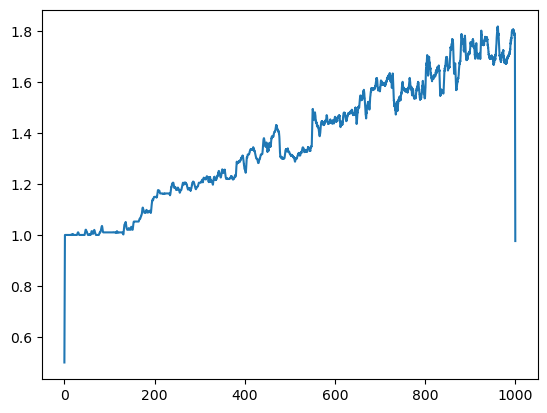

In [133]:
plt.plot(t50[::10], moving_avg)

### Radius test

In [18]:
def V(R, Omega):
    B = Omega * R2 ** 2 / (R2 ** 2 / R1 ** 2 - 1)
    return(0.5  * (B ** 2/ R ** 2 * (np.log(R2/R) - v0/B * R2) ** 2 - v0 ** 2))

In [35]:
import scipy
r_dep = scipy.optimize.fsolve(V, R1, args = 3, xtol=1e-06, maxfev=500)
print(r_dep[0])

19.878311982057344


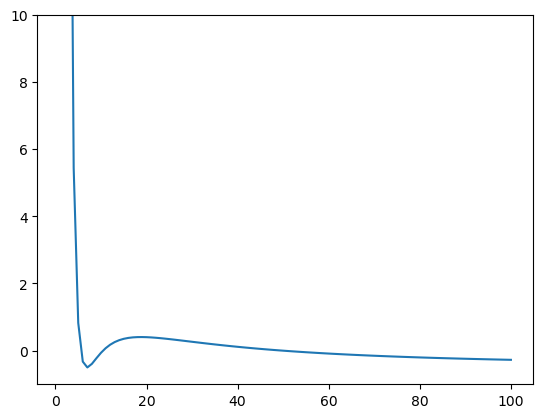

In [36]:
x = np.linspace(1, 100, 100)
plt.ylim(top = 10, bottom = -1)
plt.plot(x, V(x, 1))

# Scan

## Without gravity

In [137]:
Omegas = np.linspace(0., 1., 10)
R = []
p = []
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_46463/3374552208.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return(0.5  * (B ** 2/ R ** 2 * (np.log(R2/R) - v0/B * R2) ** 2 - v0 ** 2))
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_46463/3374552208.py:3: RuntimeWarning: invalid value encountered in multiply
  return(0.5  * (B ** 2/ R ** 2 * (np.log(R2/R) - v0/B * R2) ** 2 - v0 ** 2))
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_46463/3893087886.py:15: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  R_dep = scipy.optimize.fsolve(V, R1, args = Omegas[i], xtol=1e-06, maxfev=500)


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

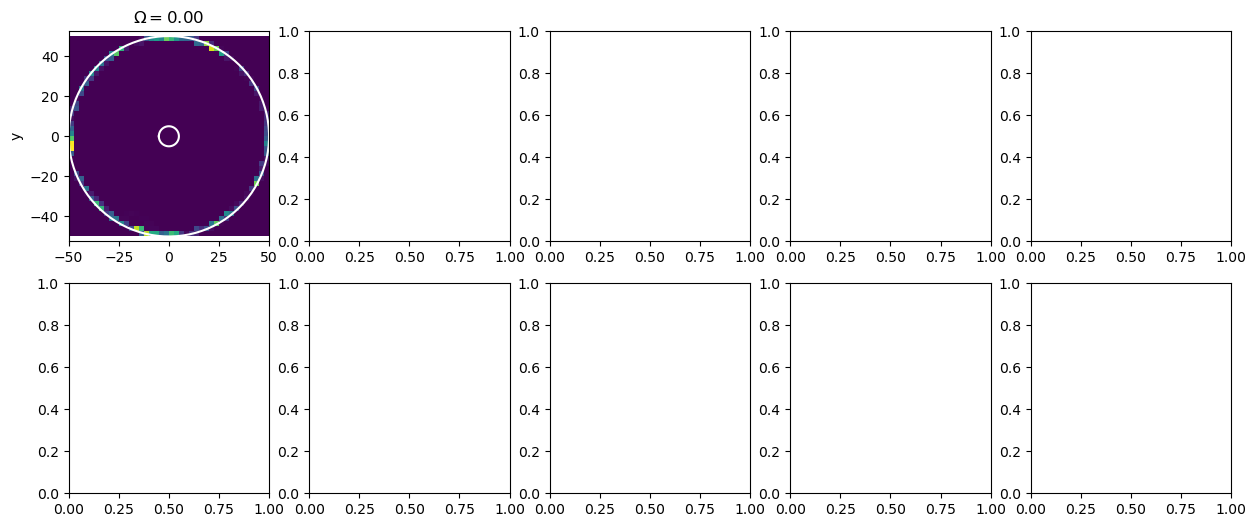

In [138]:
plot_density(R, Omegas)

In [ ]:
plot_velocity(R, Omegas)

In [ ]:
plot_delta(R, p, Omegas)

In [139]:
Omegas1 = np.linspace(1., 10., 10)
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


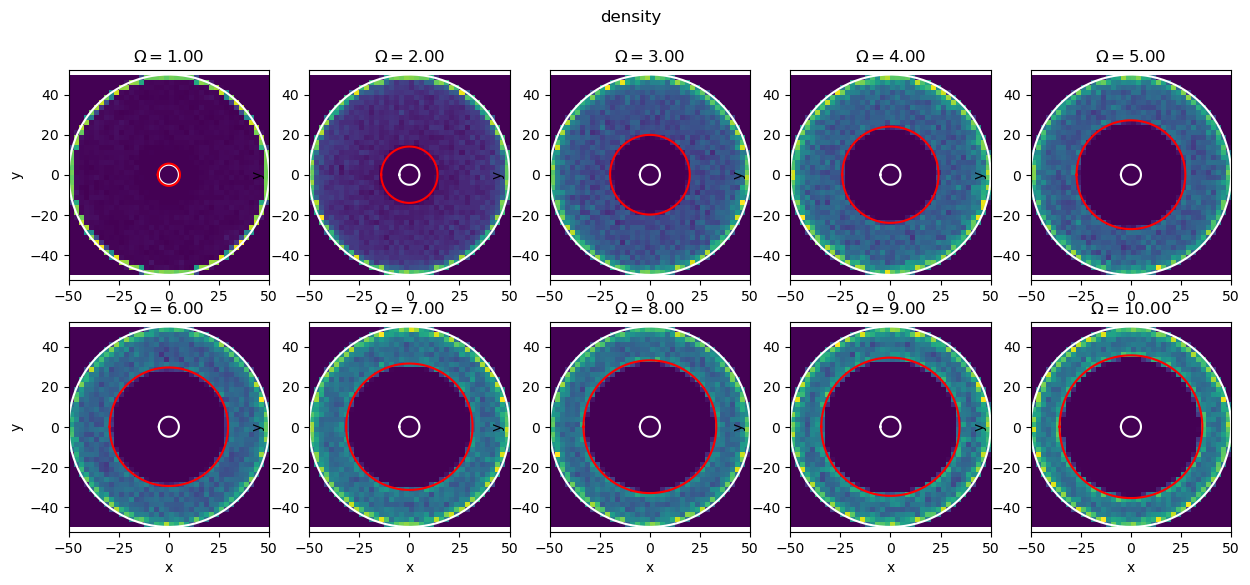

In [143]:
plot_density(R, Omegas1, depletion = True)

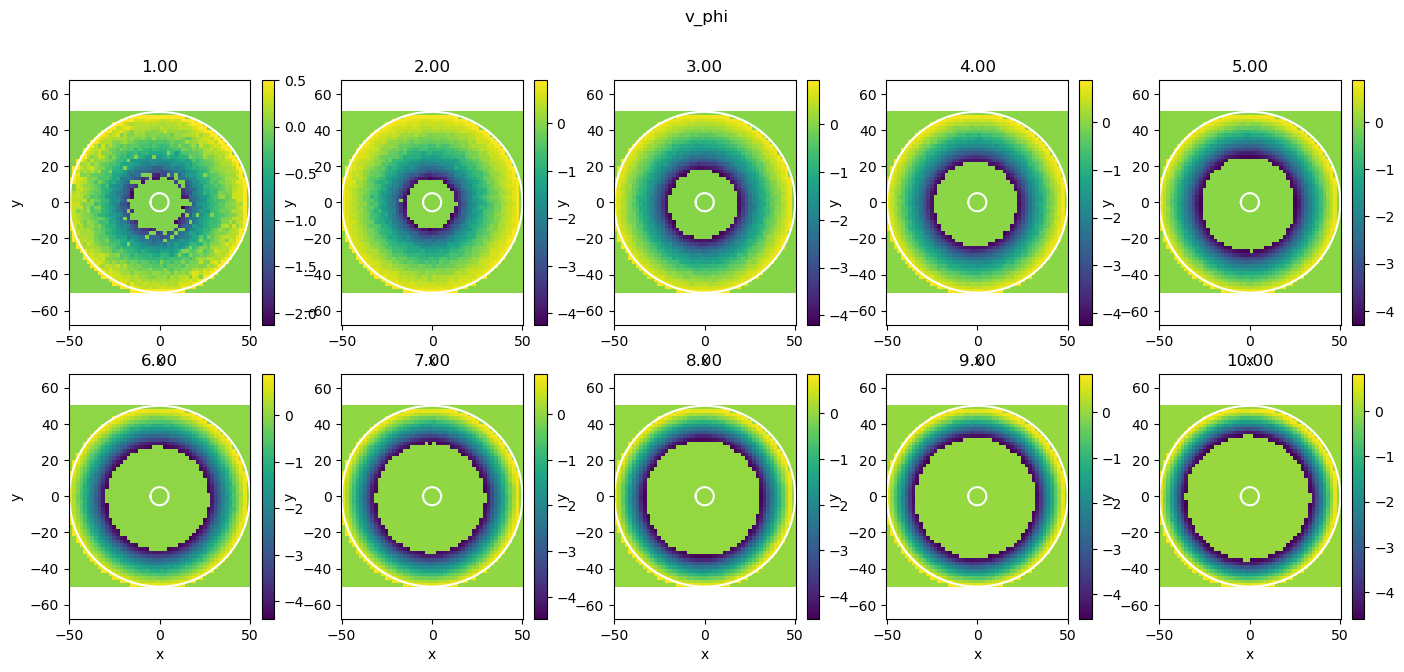

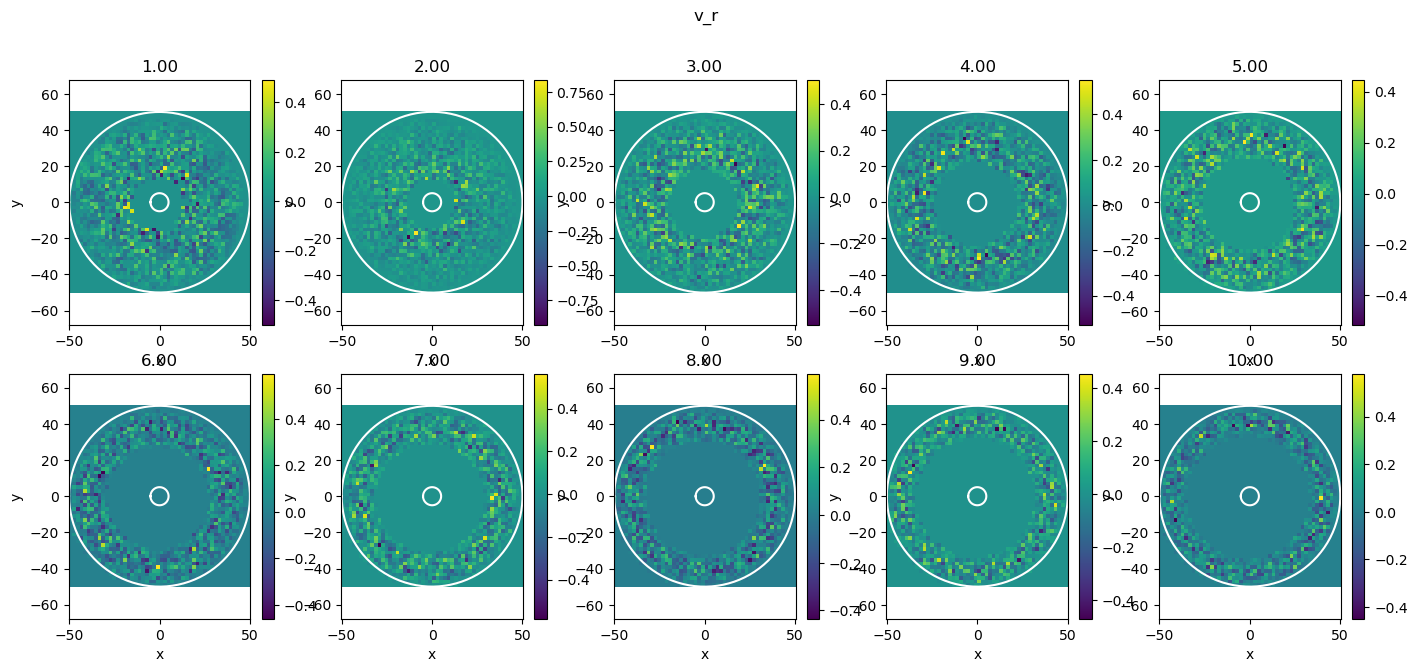

In [49]:
plot_velocity(R, Omegas1)

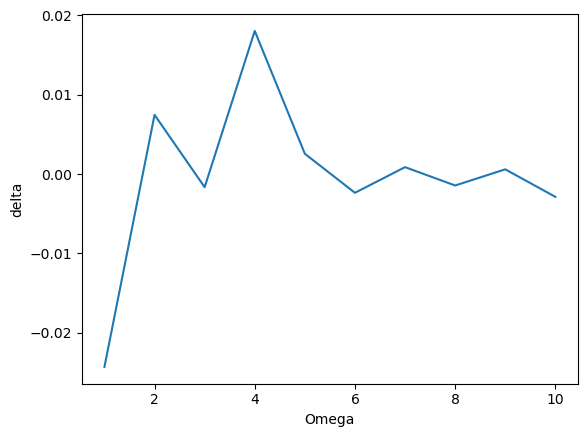

In [50]:
plot_delta(R, p, Omegas1)

### Without noise


In [51]:
Omegas1 = np.linspace(1., 10., 10)
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)
    R.append(Rs)
    p.append(ps)
    

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


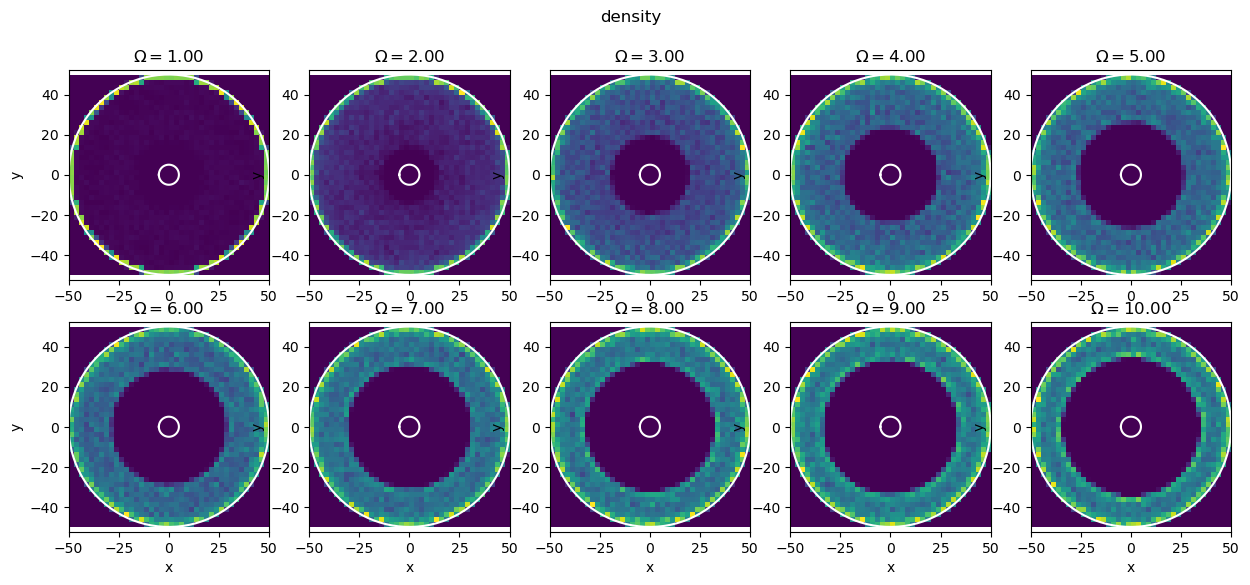

In [52]:
plot_density(R, Omegas1)

## With gravity

In [44]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


No tumbling
omega/D_R: 0.0
No tumbling
omega/D_R: 34.066837495619566
No tumbling
omega/D_R: 68.13367499123913
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


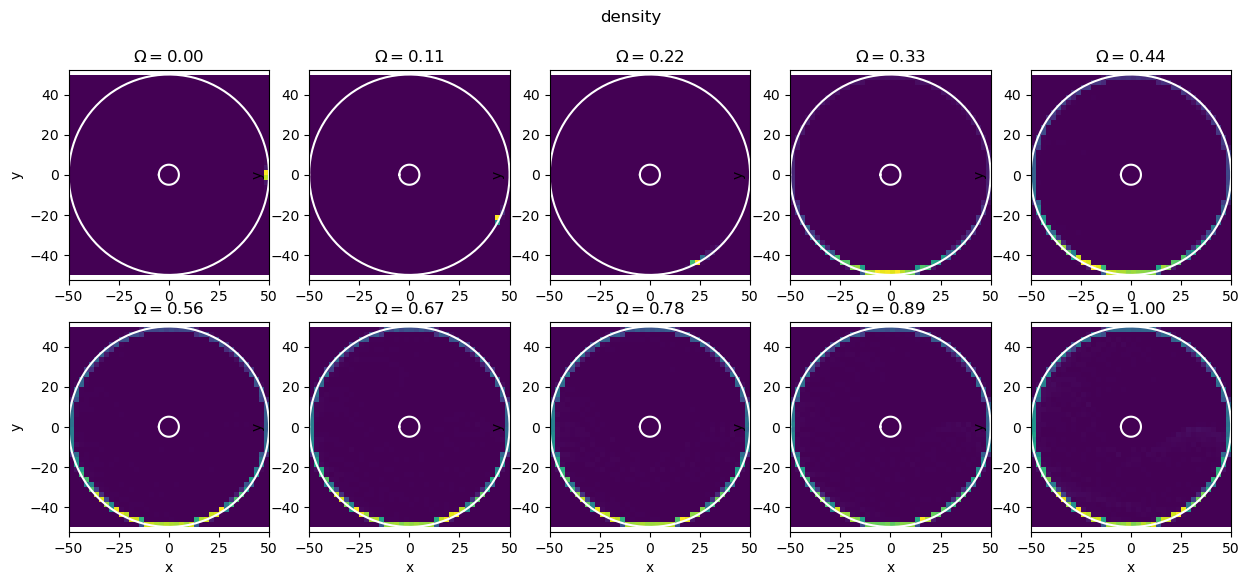

In [45]:
plot_density(R, Omegas)

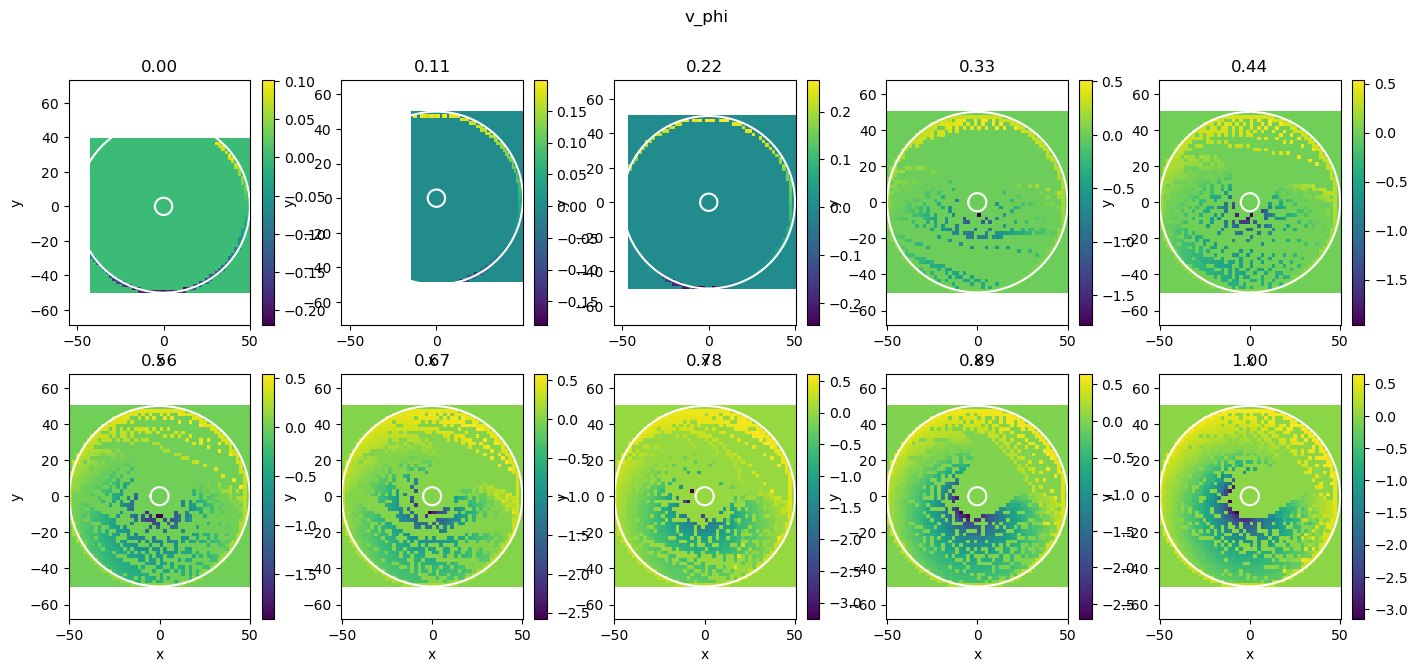

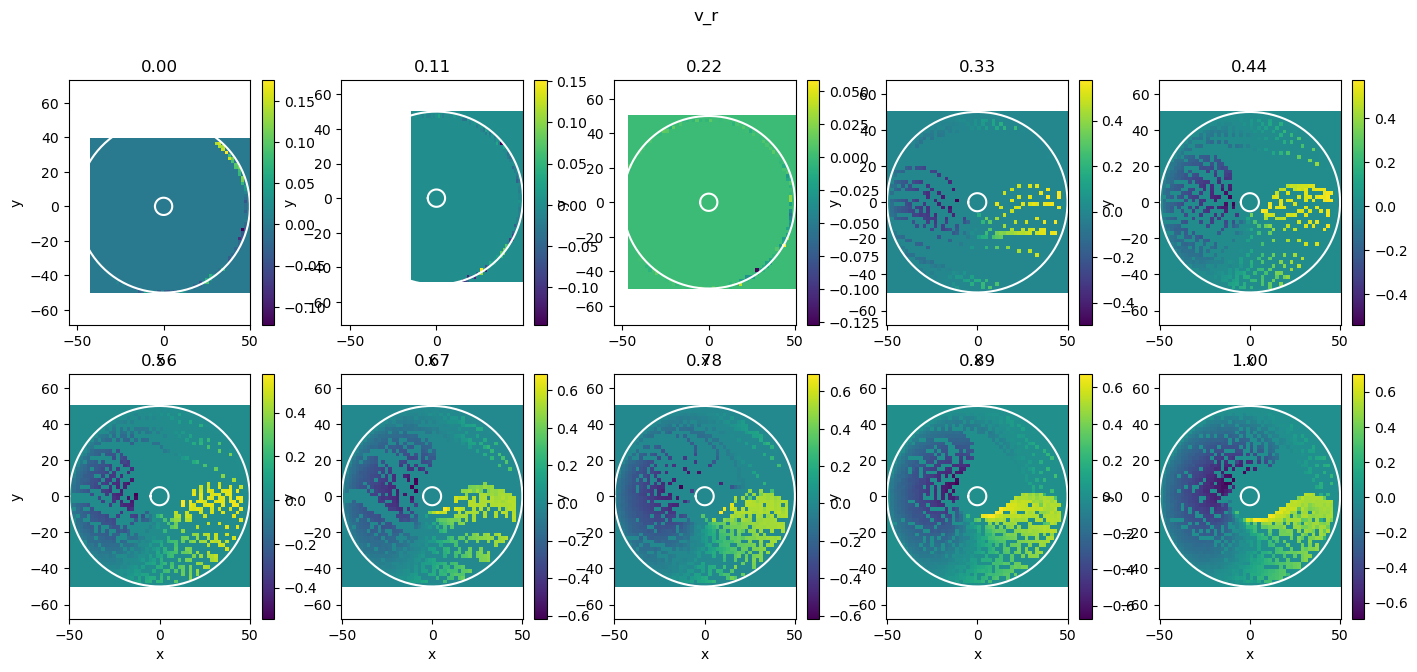

In [46]:
plot_velocity(R, Omegas)

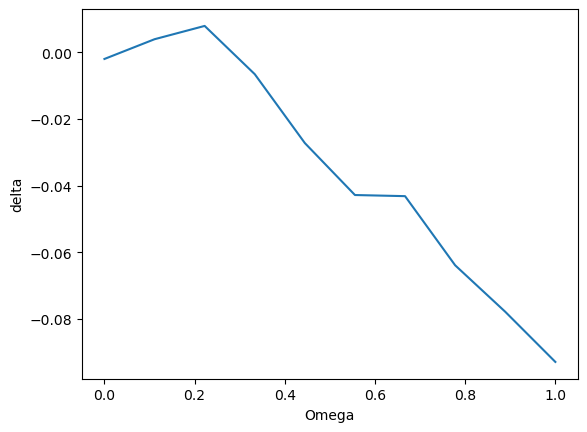

In [47]:
plot_delta(R, p, Omegas)

In [48]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


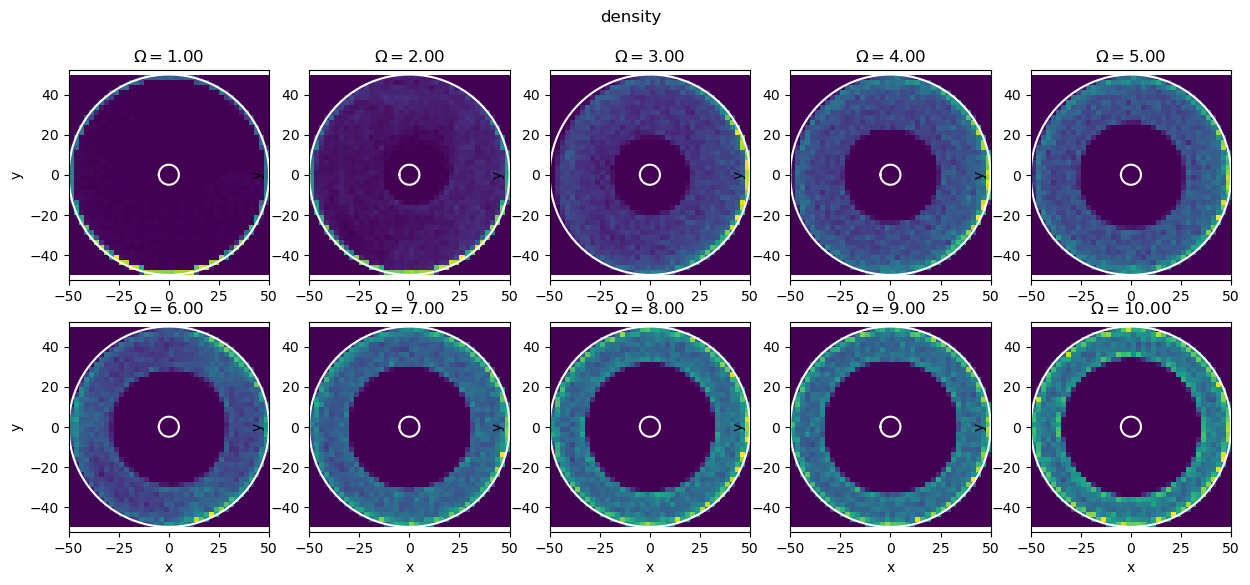

In [49]:
plot_density(R, Omegas1)

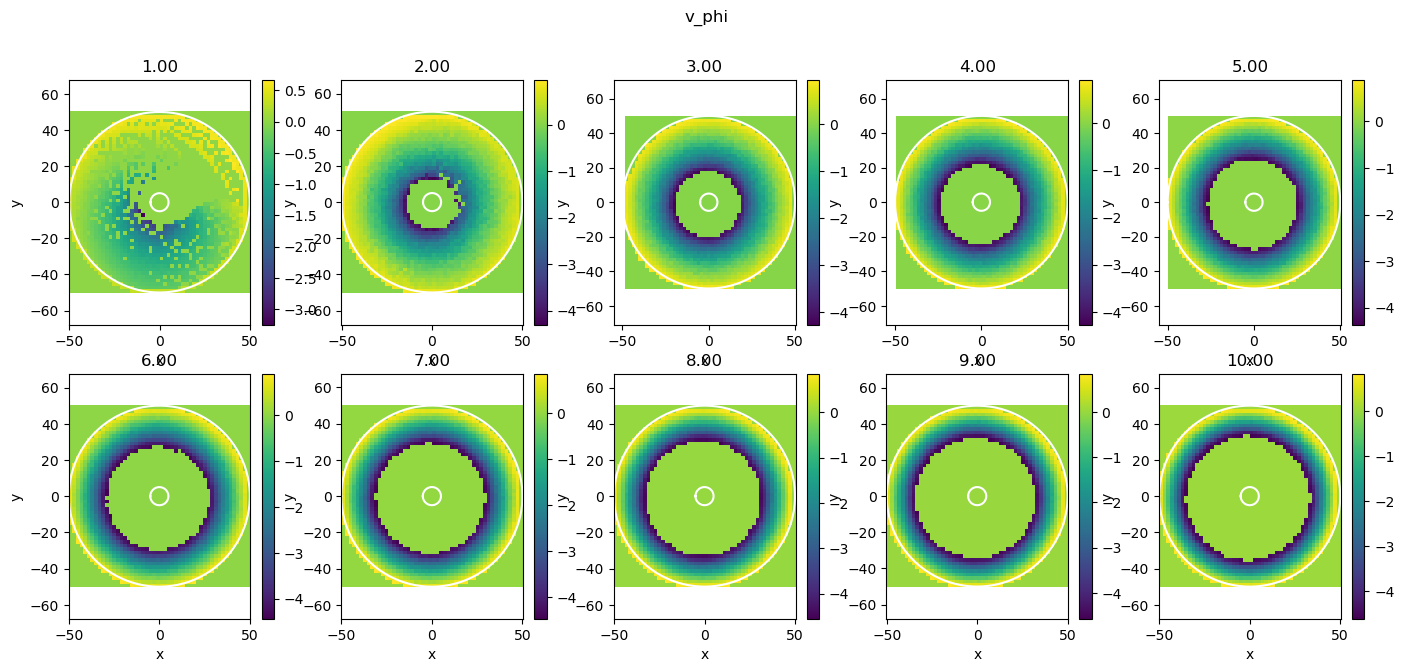

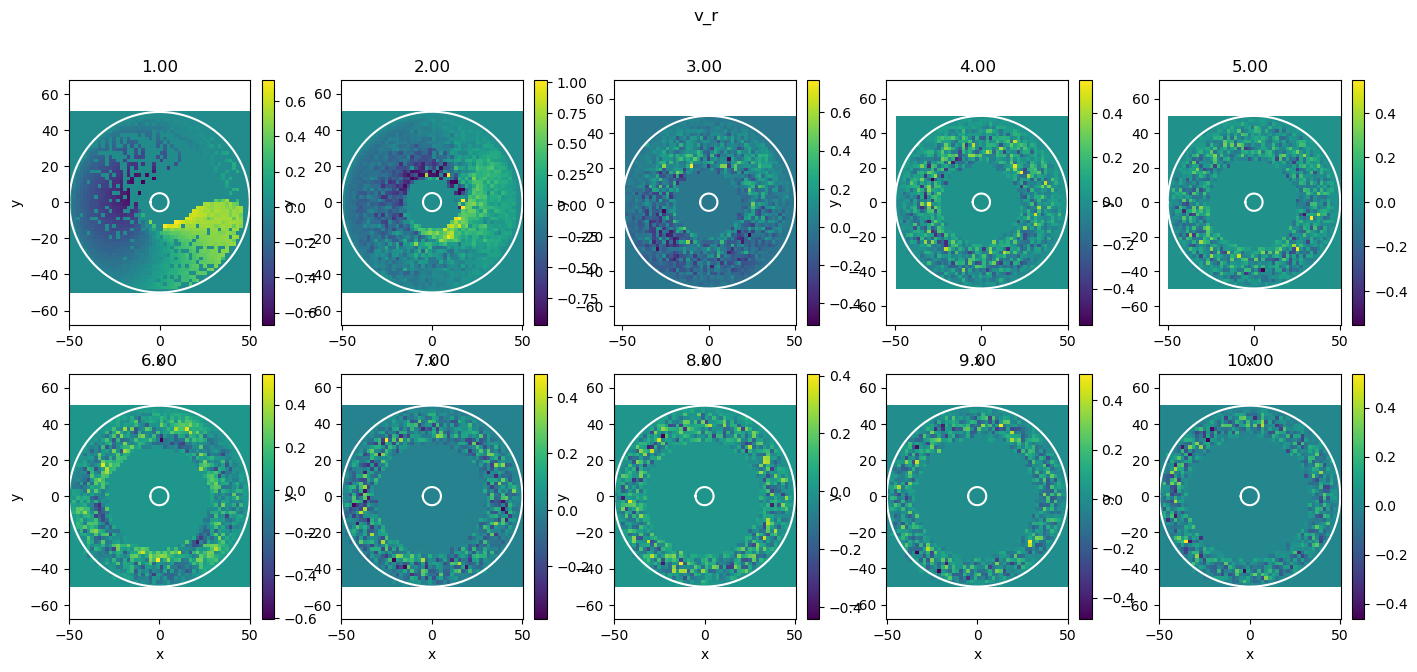

In [50]:
plot_velocity(R, Omegas1)

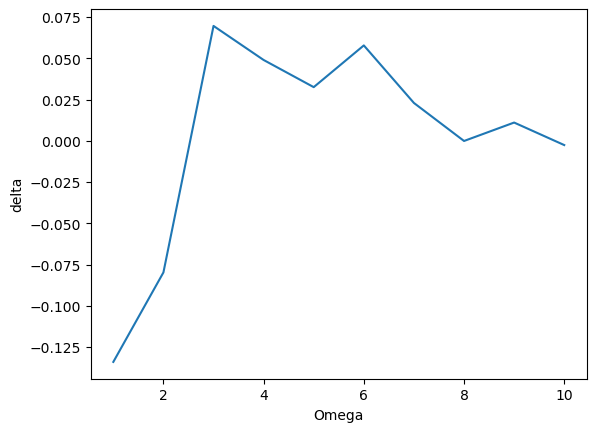

In [51]:
plot_delta(R, p, Omegas1)

## Without interaction

In [52]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


No tumbling
omega/D_R: 0.0
No tumbling
omega/D_R: 34.066837495619566
No tumbling
omega/D_R: 68.13367499123913
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


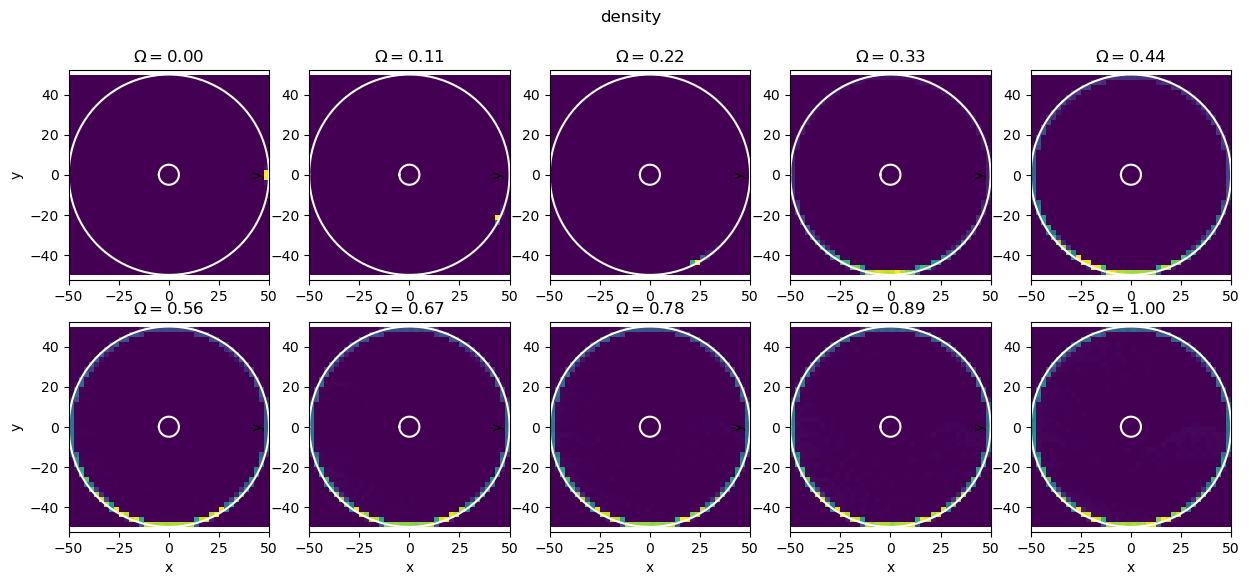

In [53]:
plot_density(R, Omegas)

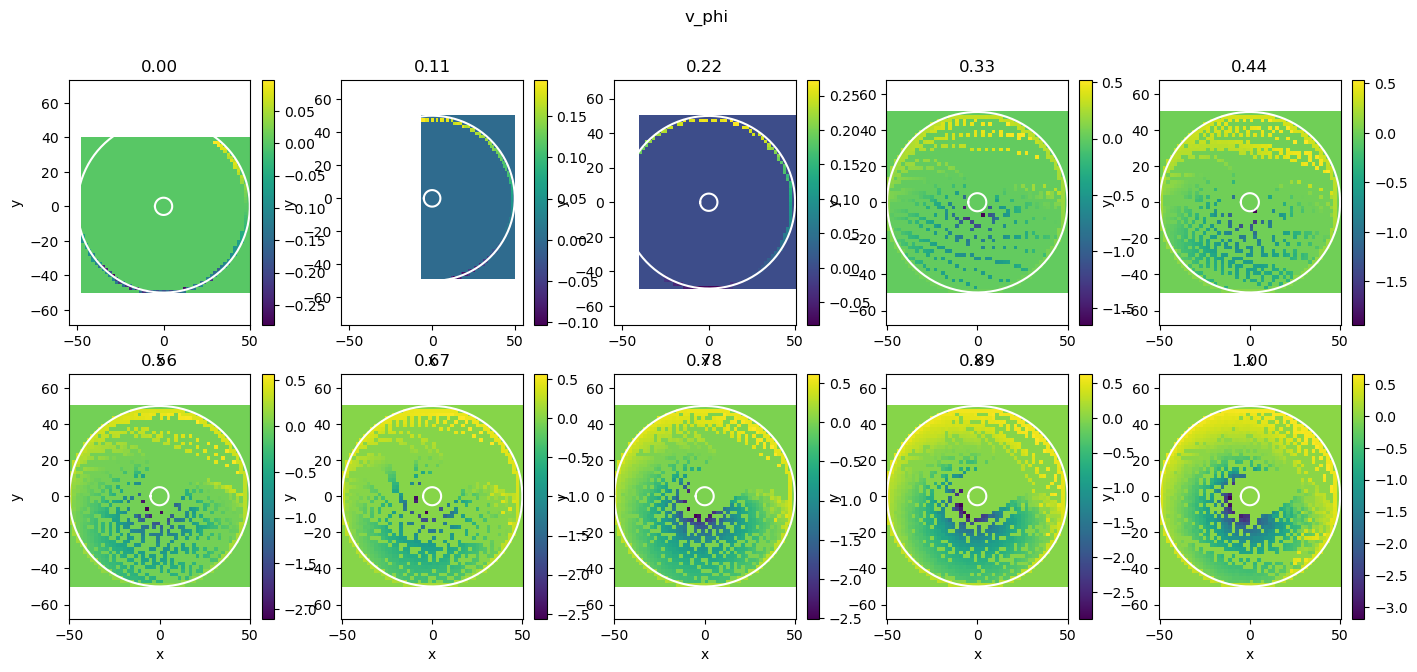

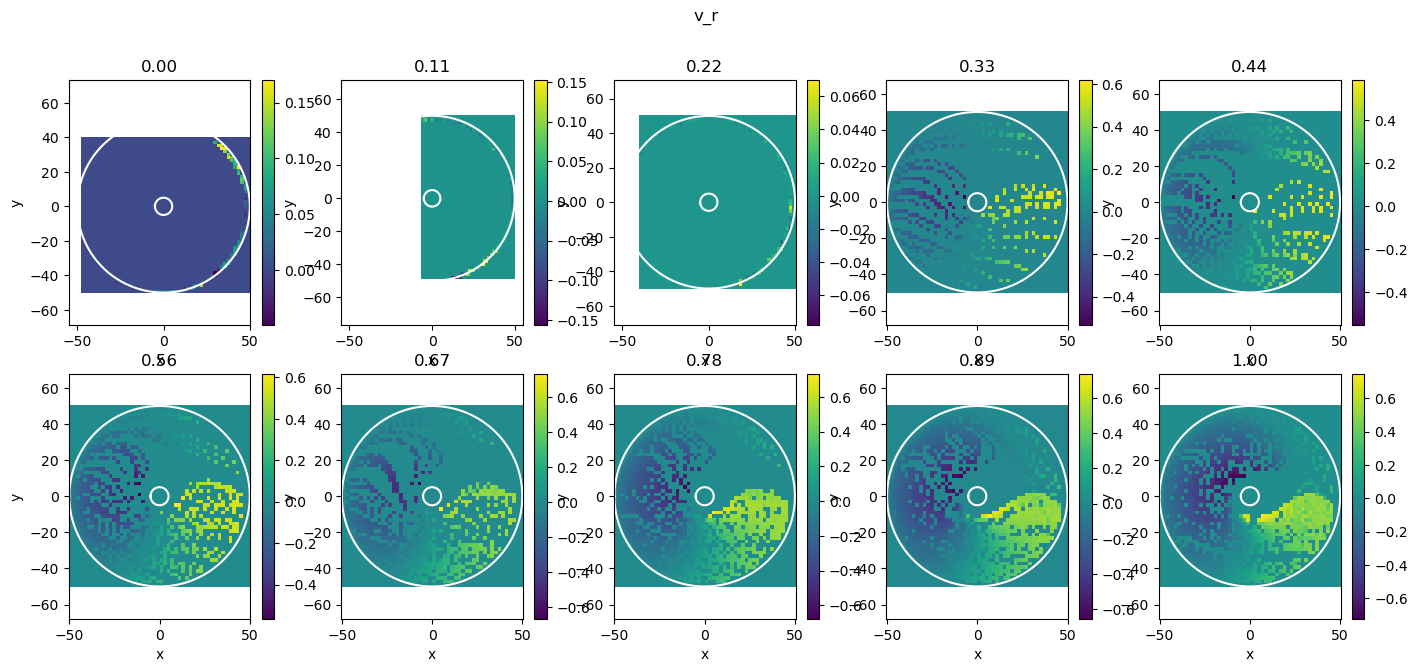

In [54]:
plot_velocity(R, Omegas)

In [55]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


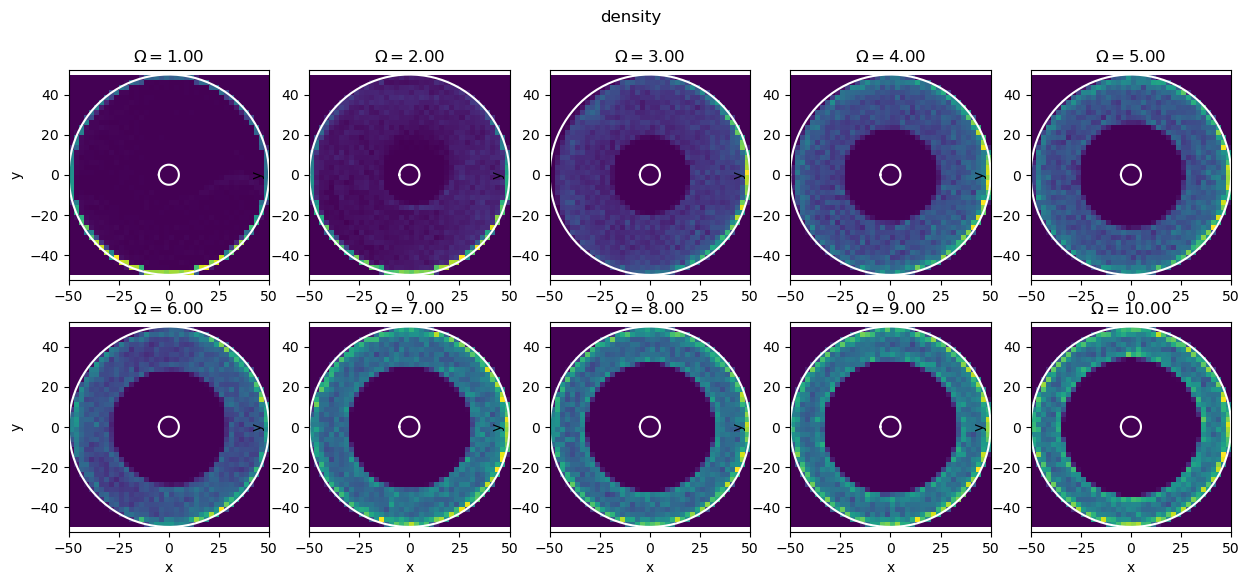

In [56]:
plot_density(R, Omegas1)

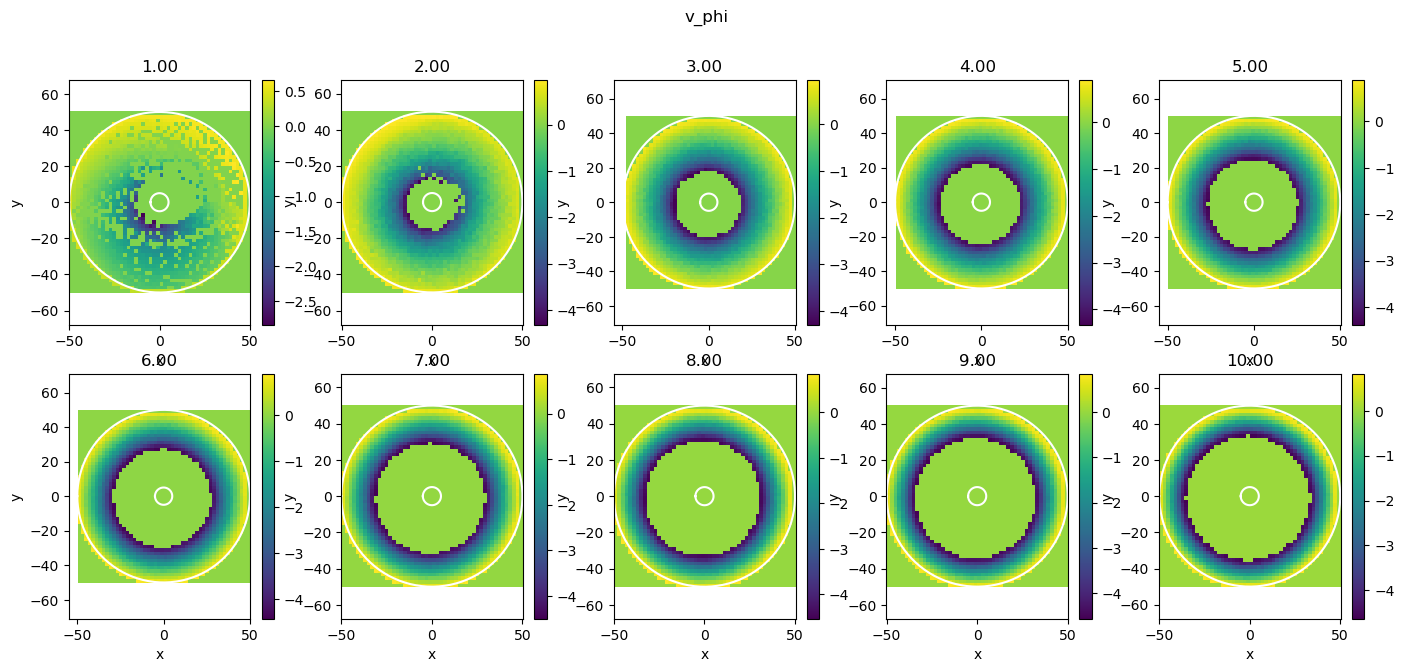

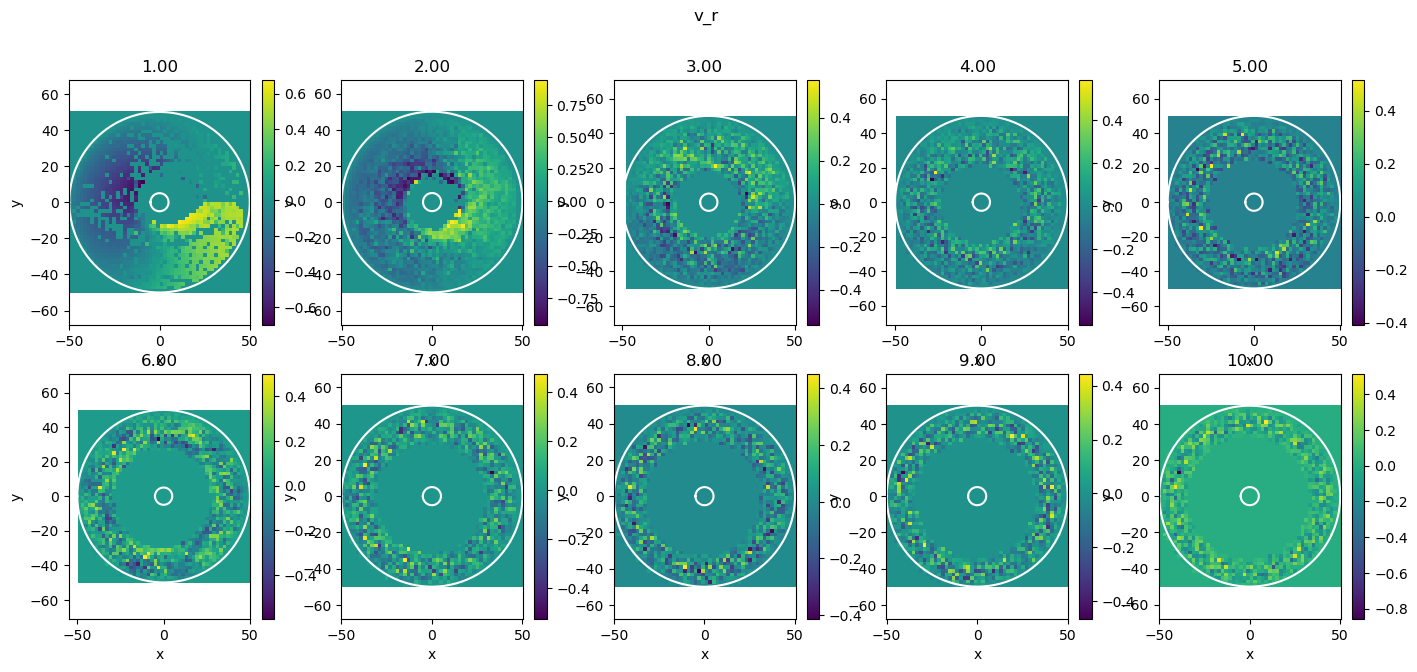

In [57]:
plot_velocity(R, Omegas1)

## With interaction

### $\varepsilon = 50$

In [58]:
ps, Rs, t = solver(3, 50, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 500000, noise = True)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [59]:
save_output(t, Rs, ps, N, 1, custom_name = "epsilon50_long", skip = 100, num = 500000)

### $\varepsilon = 10$

In [60]:
ps, Rs, t = solver(1, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 500000, noise = True)

Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


In [61]:
save_output(t, Rs, ps, N, 0.5, custom_name = "epsilon10_Omega1", skip = 100, num = 500000)

In [62]:
ps, Rs, t = solver(5, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [63]:
save_output(t, Rs, ps, N, 0.5, custom_name = "epsilon10_Omega5")

In [64]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


In [65]:
save_output(t, R[-1], p[-1], N, Omegas[-1], custom_name = "epsilon10_Omega1")

No tumbling
omega/D_R: 0.0
No tumbling
omega/D_R: 34.066837495619566
No tumbling
omega/D_R: 68.13367499123913
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


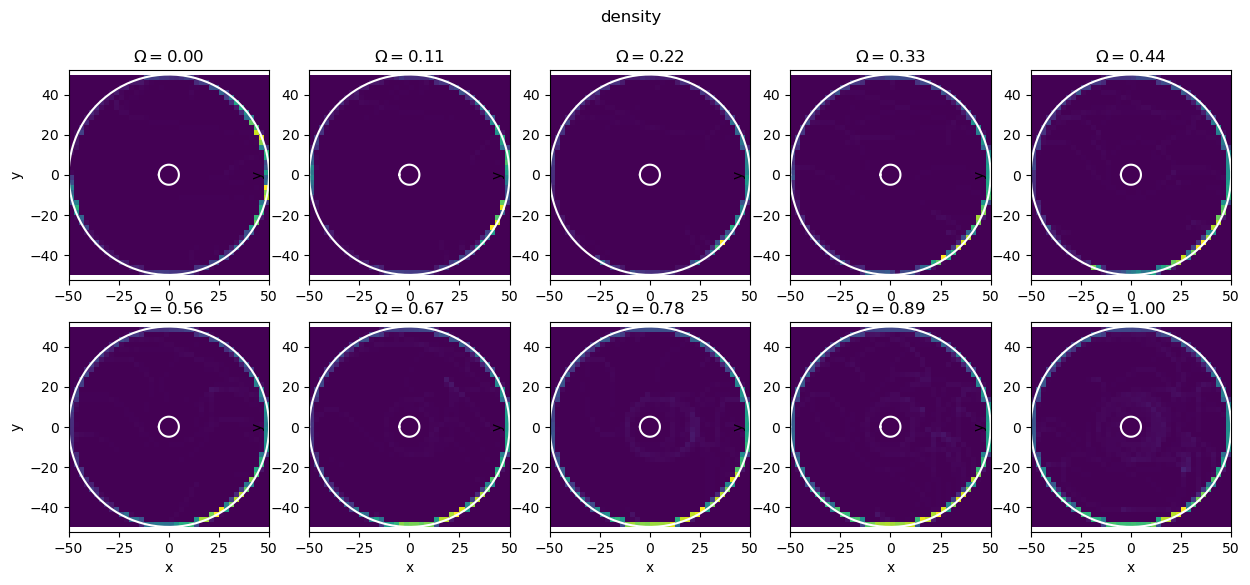

In [66]:
plot_density(R, Omegas)

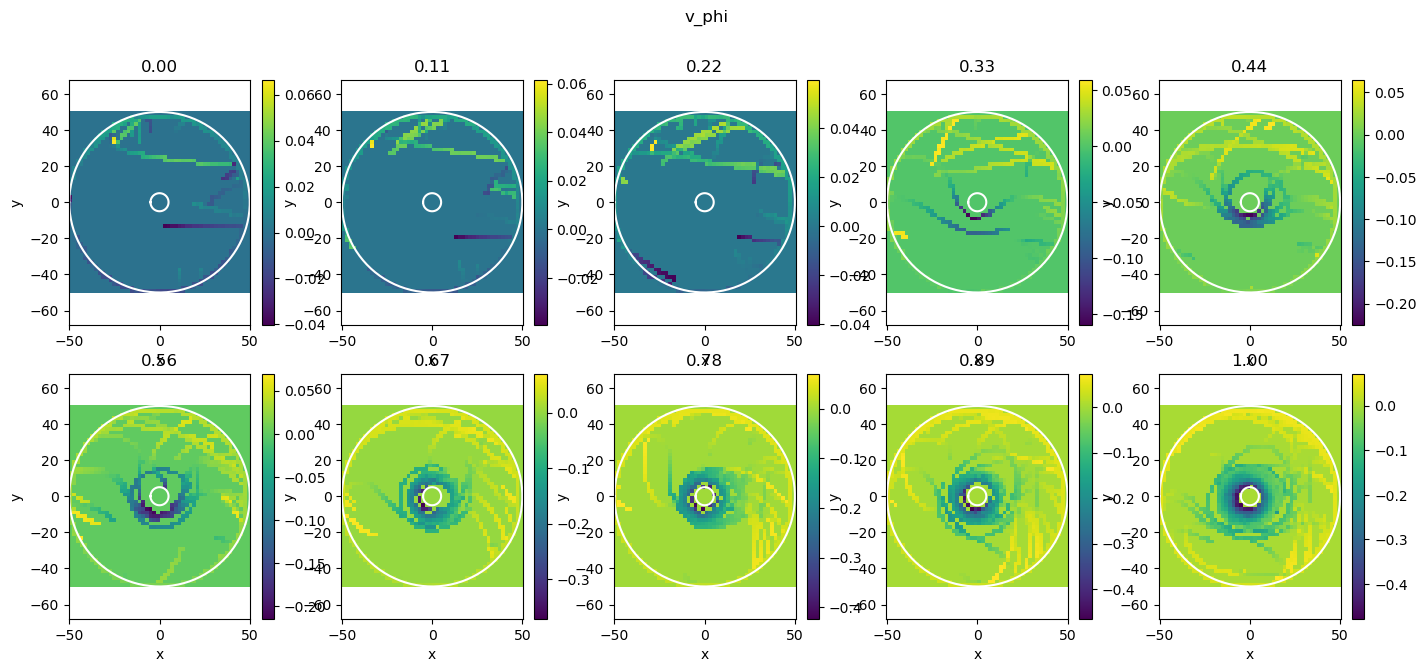

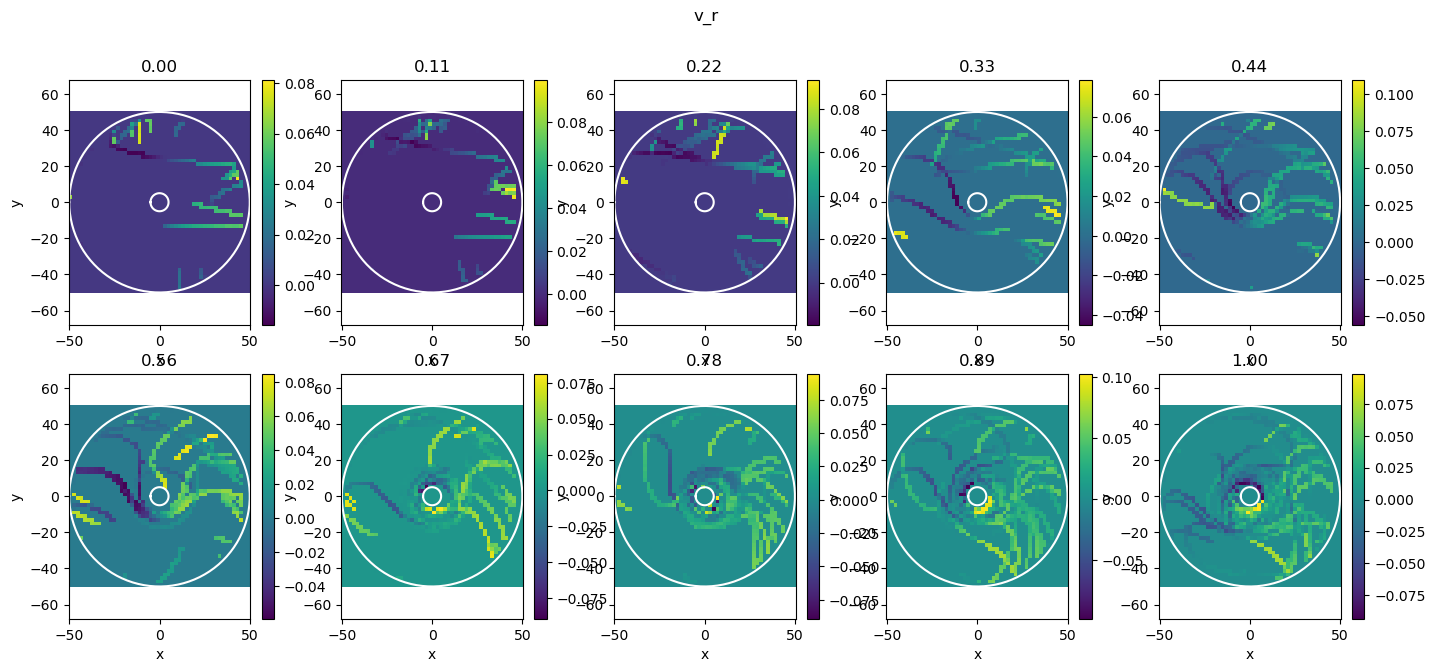

In [67]:
plot_velocity(R, Omegas)

In [68]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


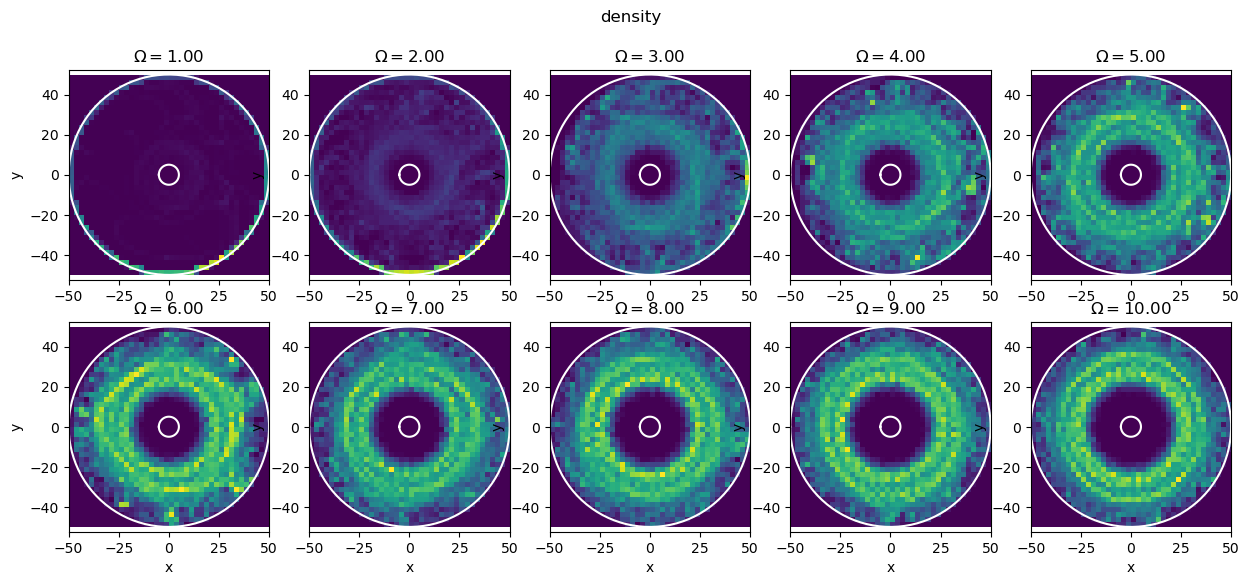

In [69]:
plot_density(R, Omegas1)

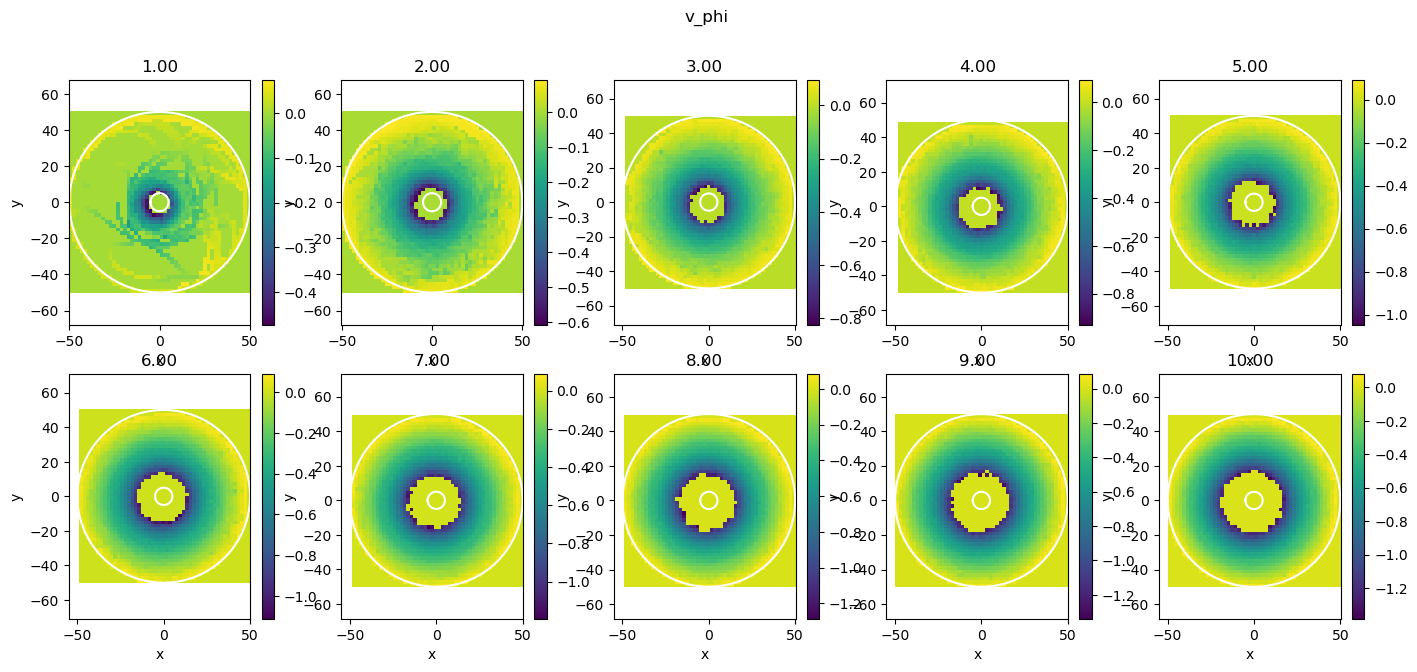

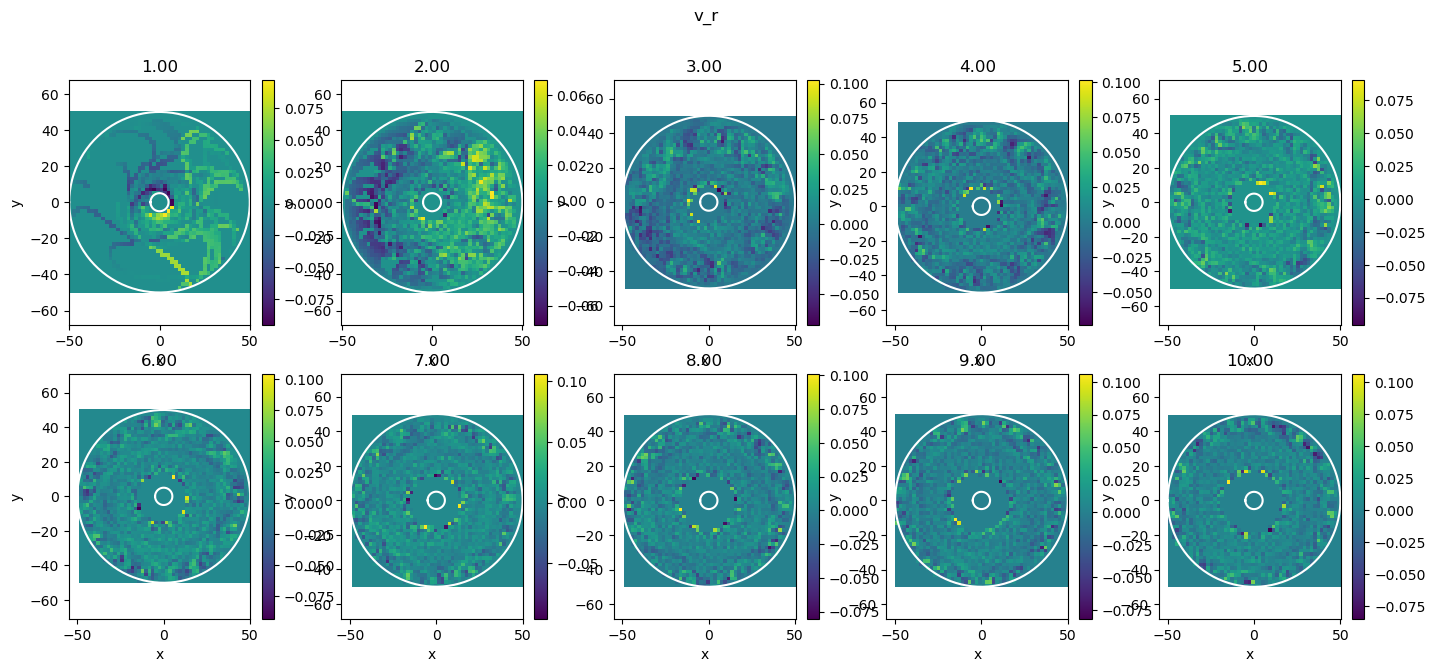

In [70]:
plot_velocity(R, Omegas1)

## Clustering

### $0<\varepsilon<50$

In [100]:
sizes = []

In [87]:
for j in range(6):
    p0s, R0s = generate_start()
    ps, Rs, t = solver(3, 55, k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    save_output(t, Rs, ps, N, 3, custom_name = f"3o/55e_{j}", num=100000)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [86]:
#R.clear()
#p.clear()
#sizes.clear()
epsilons = np.linspace(1., 50., 10)
for i in range(len(epsilons)):
    print(f'epsilon = {epsilons[i]}')
    for j in range(3):
        p0s, R0s = generate_start()
        ps, Rs, t = solver(3, epsilons[i], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
        save_output(t, Rs, ps, N, 3, custom_name = f"3o/{epsilons[i]:.2f}e_{j}", num=100000)
    #R.append(Rs)
    #p.append(ps)

    

epsilon = 1.0
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


KeyboardInterrupt: 

In [11]:
epsilons = np.linspace(1., 50., 10)

epsilons = np.append(epsilons, 55)
epsilons

array([ 1.        ,  6.44444444, 11.88888889, 17.33333333, 22.77777778,
       28.22222222, 33.66666667, 39.11111111, 44.55555556, 50.        ,
       55.        ])

In [18]:
nums = []
max_sizes = []
av_sizes = []
nums_loc = []
max_loc = []
av_loc = []
for j in range(len(epsilons)):
    nums_loc.clear()
    max_loc.clear()
    av_loc.clear()
    for k in range(6):
        clust_num = 0
        clust_size = 0 
        clust_av_size = 0
        times, Rs, ps = load_output(f"3o/{epsilons[j]:.2f}e_{k}.txt")
        #print(f"3o/{epsilons[j]:.2f}e_{k}.txt")
        clust = np.sort(fclusterdata(Rs[-2, :, :], t=2, criterion='distance'))
        #print(clust)
        clust_num += clust[-1]
        clust_size += max_repetitions(clust) 
        clust_av_size += average_size(clust)
        #clust_num = clust_num // 10
        #clust_size = clust_size // 10
        #clust_av_size = clust_av_size // 10
        nums_loc.append(clust_num)
        max_loc.append(clust_size)
        av_loc.append(clust_av_size)
    nums.append(nums_loc.copy())
    max_sizes.append(max_loc.copy())
    av_sizes.append(av_loc.copy())

nums = np.array(nums)
max_sizes = np.array(max_sizes)
av_sizes = np.array(av_sizes)

nums_mean = np.mean(nums, axis=1)
#print(nums_mean)
nums_std = np.std(nums, axis=1)

av_sizes_mean = np.mean(av_sizes, axis=1)
av_sizes_std = np.std(av_sizes, axis=1)

max_sizes_mean = np.mean(max_sizes, axis=1)
max_sizes_std = np.std(max_sizes, axis=1)


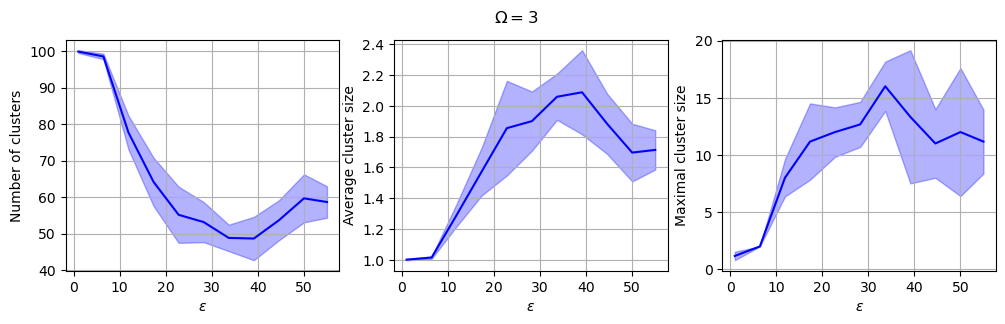

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))
axs[0].plot(epsilons, nums_mean, linestyle='-', color='blue')
axs[0].fill_between(epsilons, nums_mean - nums_std, nums_mean + nums_std, alpha=0.3, color='blue', label='±1σ')
axs[1].plot(epsilons, av_sizes_mean, linestyle='-', color='blue')
axs[1].fill_between(epsilons, av_sizes_mean - av_sizes_std, av_sizes_mean + av_sizes_std, alpha=0.3, color='blue', label='±1σ')
axs[2].plot(epsilons, max_sizes_mean, linestyle='-', color='blue')
axs[2].fill_between(epsilons, max_sizes_mean - max_sizes_std, max_sizes_mean + max_sizes_std, alpha=0.3, color='blue', label='±1σ')
axs[0].set_xlabel(r'$\varepsilon$')
axs[0].set_ylabel('Number of clusters')
axs[1].set_xlabel(r'$\varepsilon$')
axs[2].set_ylabel('Maximal cluster size')
axs[1].set_ylabel('Average cluster size')
axs[2].set_xlabel(r'$\varepsilon$')
axs[0].grid()
axs[1].grid()
axs[2].grid()

fig.suptitle(r'$\Omega = 3$')
plt.show()

In [ ]:
sizes.clear()
for i in range(len(R)):
    av_sizes = get_av_cluster_size(R[i])
    sizes.append(av_sizes)

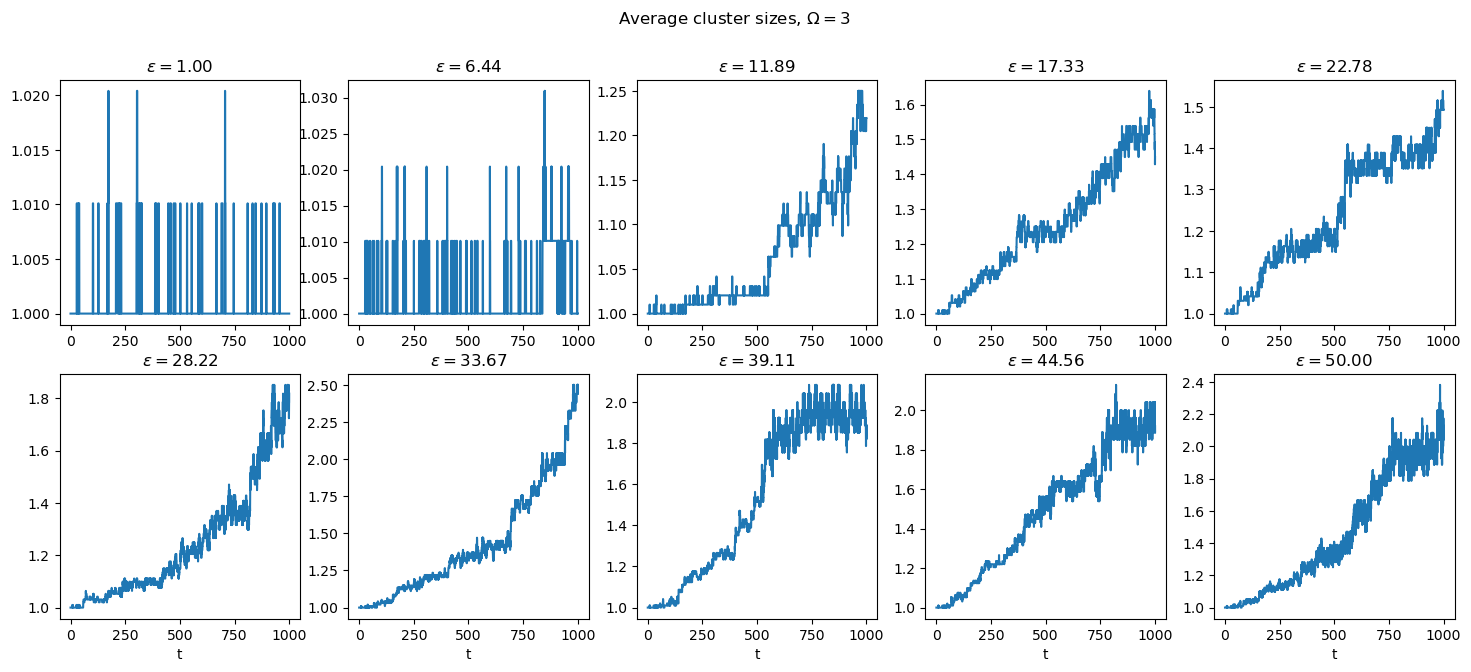

In [159]:
fig, axs = plt.subplots(2, 5, figsize = (18,7))
for i in range(len(epsilons)):
    axs[i // 5, i % 5].plot(t[::10], sizes[i])
    if i//5 != 0:
        axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
    axs[i // 5, i % 5].set_title(r'$\varepsilon = $'+f'{epsilons[i]:.2f}')
    
fig.suptitle(r'Average cluster sizes, $\Omega = 3$')
plt.show()

In [ ]:

R.clear()
p.clear()
sizes.clear()
epsilons = np.linspace(1., 50., 10)
for i in range(len(epsilons)):
    print(i)
    ps, Rs, t = solver(1, epsilons[i], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    R.append(Rs)
    p.append(ps)
    sizes.append(get_av_cluster_size(Rs))

AttributeError: 'int' object has no attribute 'clear'

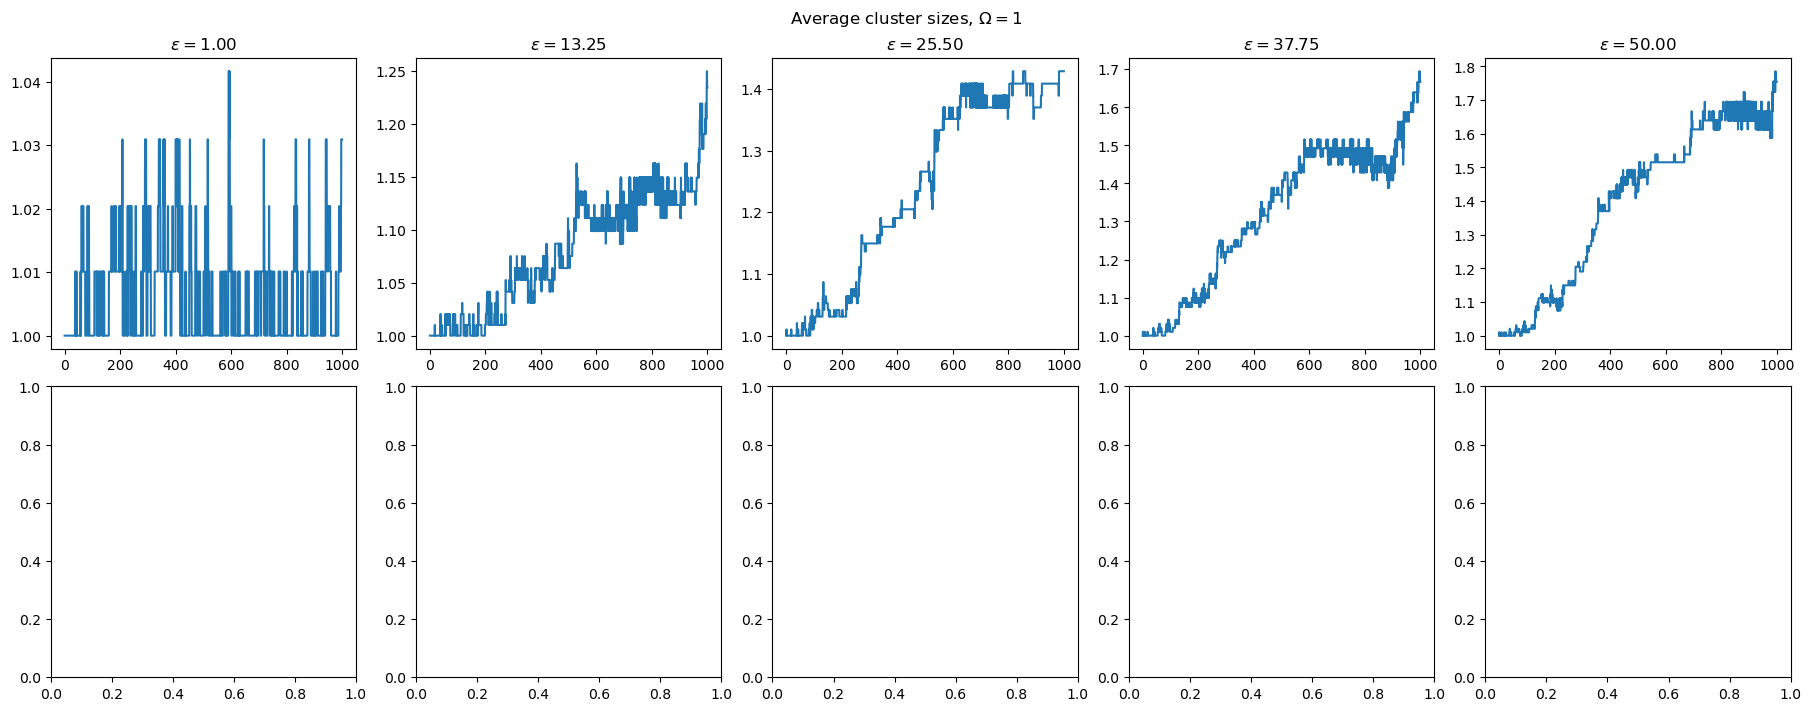

In [193]:
fig, axs = plt.subplots(2, 5, figsize = (18,7), layout = 'constrained')
for i in range(len(epsilons)):
    axs[i // 5, i % 5].plot(t[::10], sizes[i])
    if i//5 != 0:
        axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
    axs[i // 5, i % 5].set_title(r'$\varepsilon = $'+f'{epsilons[i]:.2f}')
    
fig.suptitle(r'Average cluster sizes, $\Omega = 1$')
plt.show()

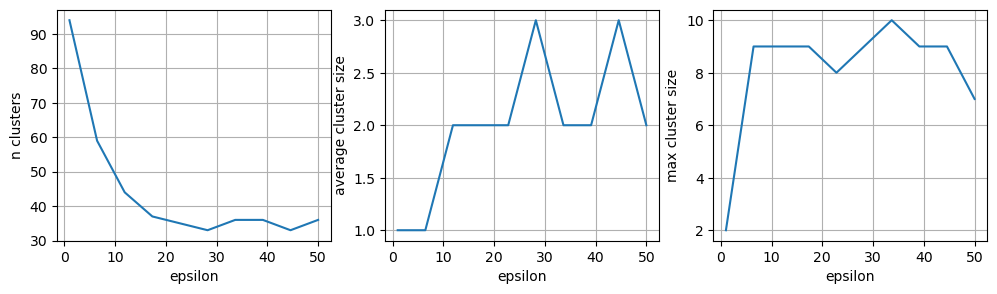

In [166]:
nums = []
max_sizes = []
av_sizes = []
for j in range(len(epsilons)):
    clust_num = 0
    clust_size = 0 
    clust_av_size = 0
    for i in range(0, 100, 10):
        clust = np.sort(fclusterdata(R[j][ -1 - i, :, :], t=3, criterion='distance'))
        clust_num += clust[-1]
        clust_size += max_repetitions(clust) 
        clust_av_size += average_size(clust)
    clust_num = clust_num // len(epsilons)
    clust_size = clust_size // len(epsilons)
    clust_av_size = clust_av_size // len(epsilons)
    nums.append(clust_num)
    max_sizes.append(clust_size)
    av_sizes.append(clust_av_size)

fig, axs = plt.subplots(1, 3, figsize = (12,3))
axs[0].plot(epsilons, nums)
axs[2].plot(epsilons, max_sizes)
axs[1].plot(epsilons, av_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[2].set_ylabel('max cluster size')
axs[1].set_ylabel('average cluster size')
axs[2].set_xlabel('epsilon')
axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.show()

In [195]:
np.meshgrid(epsilons, omegas)

(array([[ 1.  , 13.25, 25.5 , 37.75, 50.  ],
        [ 1.  , 13.25, 25.5 , 37.75, 50.  ],
        [ 1.  , 13.25, 25.5 , 37.75, 50.  ],
        [ 1.  , 13.25, 25.5 , 37.75, 50.  ],
        [ 1.  , 13.25, 25.5 , 37.75, 50.  ]]),
 array([[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.9, 0.9, 0.9, 0.9, 0.9],
        [1.6, 1.6, 1.6, 1.6, 1.6],
        [2.3, 2.3, 2.3, 2.3, 2.3],
        [3. , 3. , 3. , 3. , 3. ]]))

In [ ]:
epsilons = np.linspace(1., 50., 5)
omegas = np.linspace(0.2, 3., 5)
e, o = np.meshgrid(epsilons, omegas)
#sizes_eo = np.empty((5, 5, 10000))
for i in range(5):
    for j in range(5):
        print(i, j)
        ps, Rs, t = solver(o[i, j], e[i, j], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
        save_output(t, Rs, ps, N, o[i, j], custom_name = f"{o[i,j]:.2f}o_{e[i,j]:.2f}e")
        #sizes_eo[i, j] = get_av_cluster_size(Rs)

0 0
No tumbling
omega/D_R: 61.32030749211523
0 1
No tumbling
omega/D_R: 61.32030749211523
0 2
No tumbling
omega/D_R: 61.32030749211523
0 3
No tumbling
omega/D_R: 61.32030749211523
0 4
No tumbling
omega/D_R: 61.32030749211523
1 0
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
1 1
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
1 2
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
1 3
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
1 4
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
2 0
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
2 1
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
2 2
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
2 3
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
2 4
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
3 0
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
3 1
Tumbling period: 272.02

In [76]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/1767037418.py:20: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'f'{o[i, j]:.2f}'


done for omega 0.20 epsilon 1.00
done for omega 0.20 epsilon 13.25
done for omega 0.20 epsilon 25.50
done for omega 0.20 epsilon 37.75
done for omega 0.20 epsilon 50.00
done for omega 0.90 epsilon 1.00
done for omega 0.90 epsilon 13.25
done for omega 0.90 epsilon 25.50
done for omega 0.90 epsilon 37.75
done for omega 0.90 epsilon 50.00
done for omega 1.60 epsilon 1.00
done for omega 1.60 epsilon 13.25
done for omega 1.60 epsilon 25.50
done for omega 1.60 epsilon 37.75
done for omega 1.60 epsilon 50.00
done for omega 2.30 epsilon 1.00
done for omega 2.30 epsilon 13.25
done for omega 2.30 epsilon 25.50
done for omega 2.30 epsilon 37.75
done for omega 2.30 epsilon 50.00
done for omega 3.00 epsilon 1.00
done for omega 3.00 epsilon 13.25
done for omega 3.00 epsilon 25.50
done for omega 3.00 epsilon 37.75
done for omega 3.00 epsilon 50.00


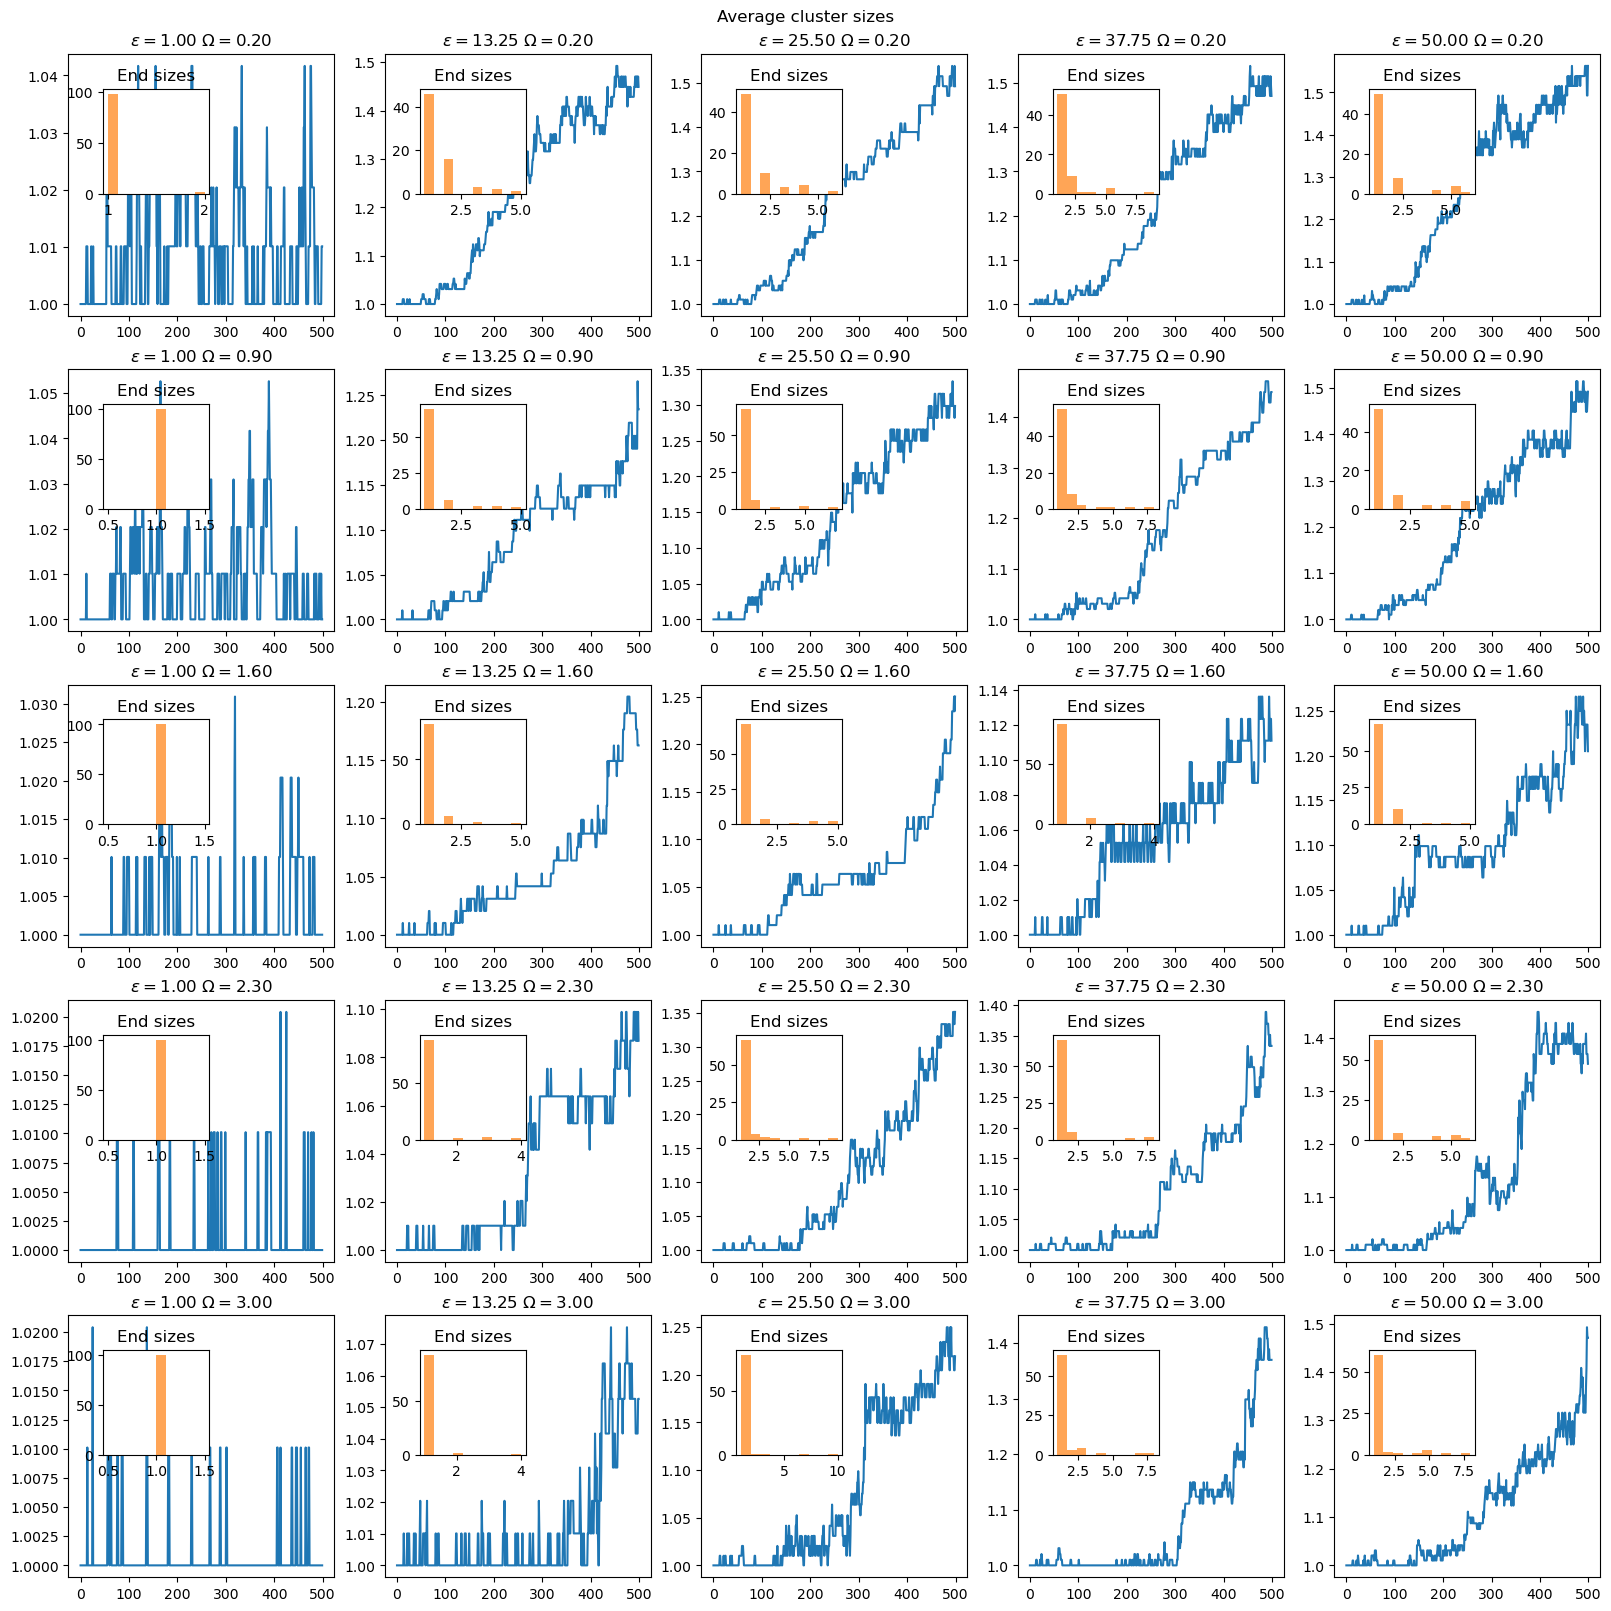

In [81]:
epsilons = np.linspace(1., 50., 5)
omegas = np.linspace(0.2, 3., 5)
e, o = np.meshgrid(epsilons, omegas)
fig, axs = plt.subplots(5, 5, figsize = (16,16), layout = 'constrained')
for i in range(5):
    for j in range(5):
        times, Rs, ps = load_output(f"{o[i,j]:.2f}o_{e[i,j]:.2f}e.txt")
        sizes = get_av_cluster_size(Rs)
        print(f'done for omega {o[i,j]:.2f} epsilon {e[i,j]:.2f}')
        #axs[i, j].plot(t[::10], sizes_eo[i, j])
        axs[i, j].plot(times[::10], sizes, label = 'average')

        #max_sizes = get_max_cluster_size(Rs)
        #axs[i, j].plot(times[::10], max_sizes, label = 'maximal')
        #moving_avg = np.convolve(sizes_eo[i, j], np.ones(window_size)/window_size, mode='same')
        #axs[i, j].plot(t[::10], moving_avg)
    #if i//5 != 0:
        #axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
        title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'f'{o[i, j]:.2f}'
        axs[i, j].set_title(title)
        #axs[i, j].legend

        axins = inset_axes(axs[i,j], width="40%", height="40%", loc="upper left", borderpad=2.5)
        axins.hist(get_size_distribution(Rs[-1,:,:]), bins=10, color="tab:orange", alpha=0.7)
        axins.set_title('End sizes')
    
fig.suptitle(r'Average cluster sizes')
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\O'
<>:14: SyntaxWarning: invalid escape sequence '\O'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_10171/3524724238.py:14: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'f'{o[i, j]:.2f}'


done for omega 0.20 epsilon 1.00
done for omega 0.20 epsilon 13.25
done for omega 0.20 epsilon 25.50
done for omega 0.20 epsilon 37.75
done for omega 0.20 epsilon 50.00
done for omega 0.90 epsilon 1.00
done for omega 0.90 epsilon 13.25
done for omega 0.90 epsilon 25.50
done for omega 0.90 epsilon 37.75
done for omega 0.90 epsilon 50.00
done for omega 1.60 epsilon 1.00
done for omega 1.60 epsilon 13.25
done for omega 1.60 epsilon 25.50
done for omega 1.60 epsilon 37.75
done for omega 1.60 epsilon 50.00
done for omega 2.30 epsilon 1.00
done for omega 2.30 epsilon 13.25
done for omega 2.30 epsilon 25.50
done for omega 2.30 epsilon 37.75
done for omega 2.30 epsilon 50.00
done for omega 3.00 epsilon 1.00
done for omega 3.00 epsilon 13.25
done for omega 3.00 epsilon 25.50
done for omega 3.00 epsilon 37.75
done for omega 3.00 epsilon 50.00


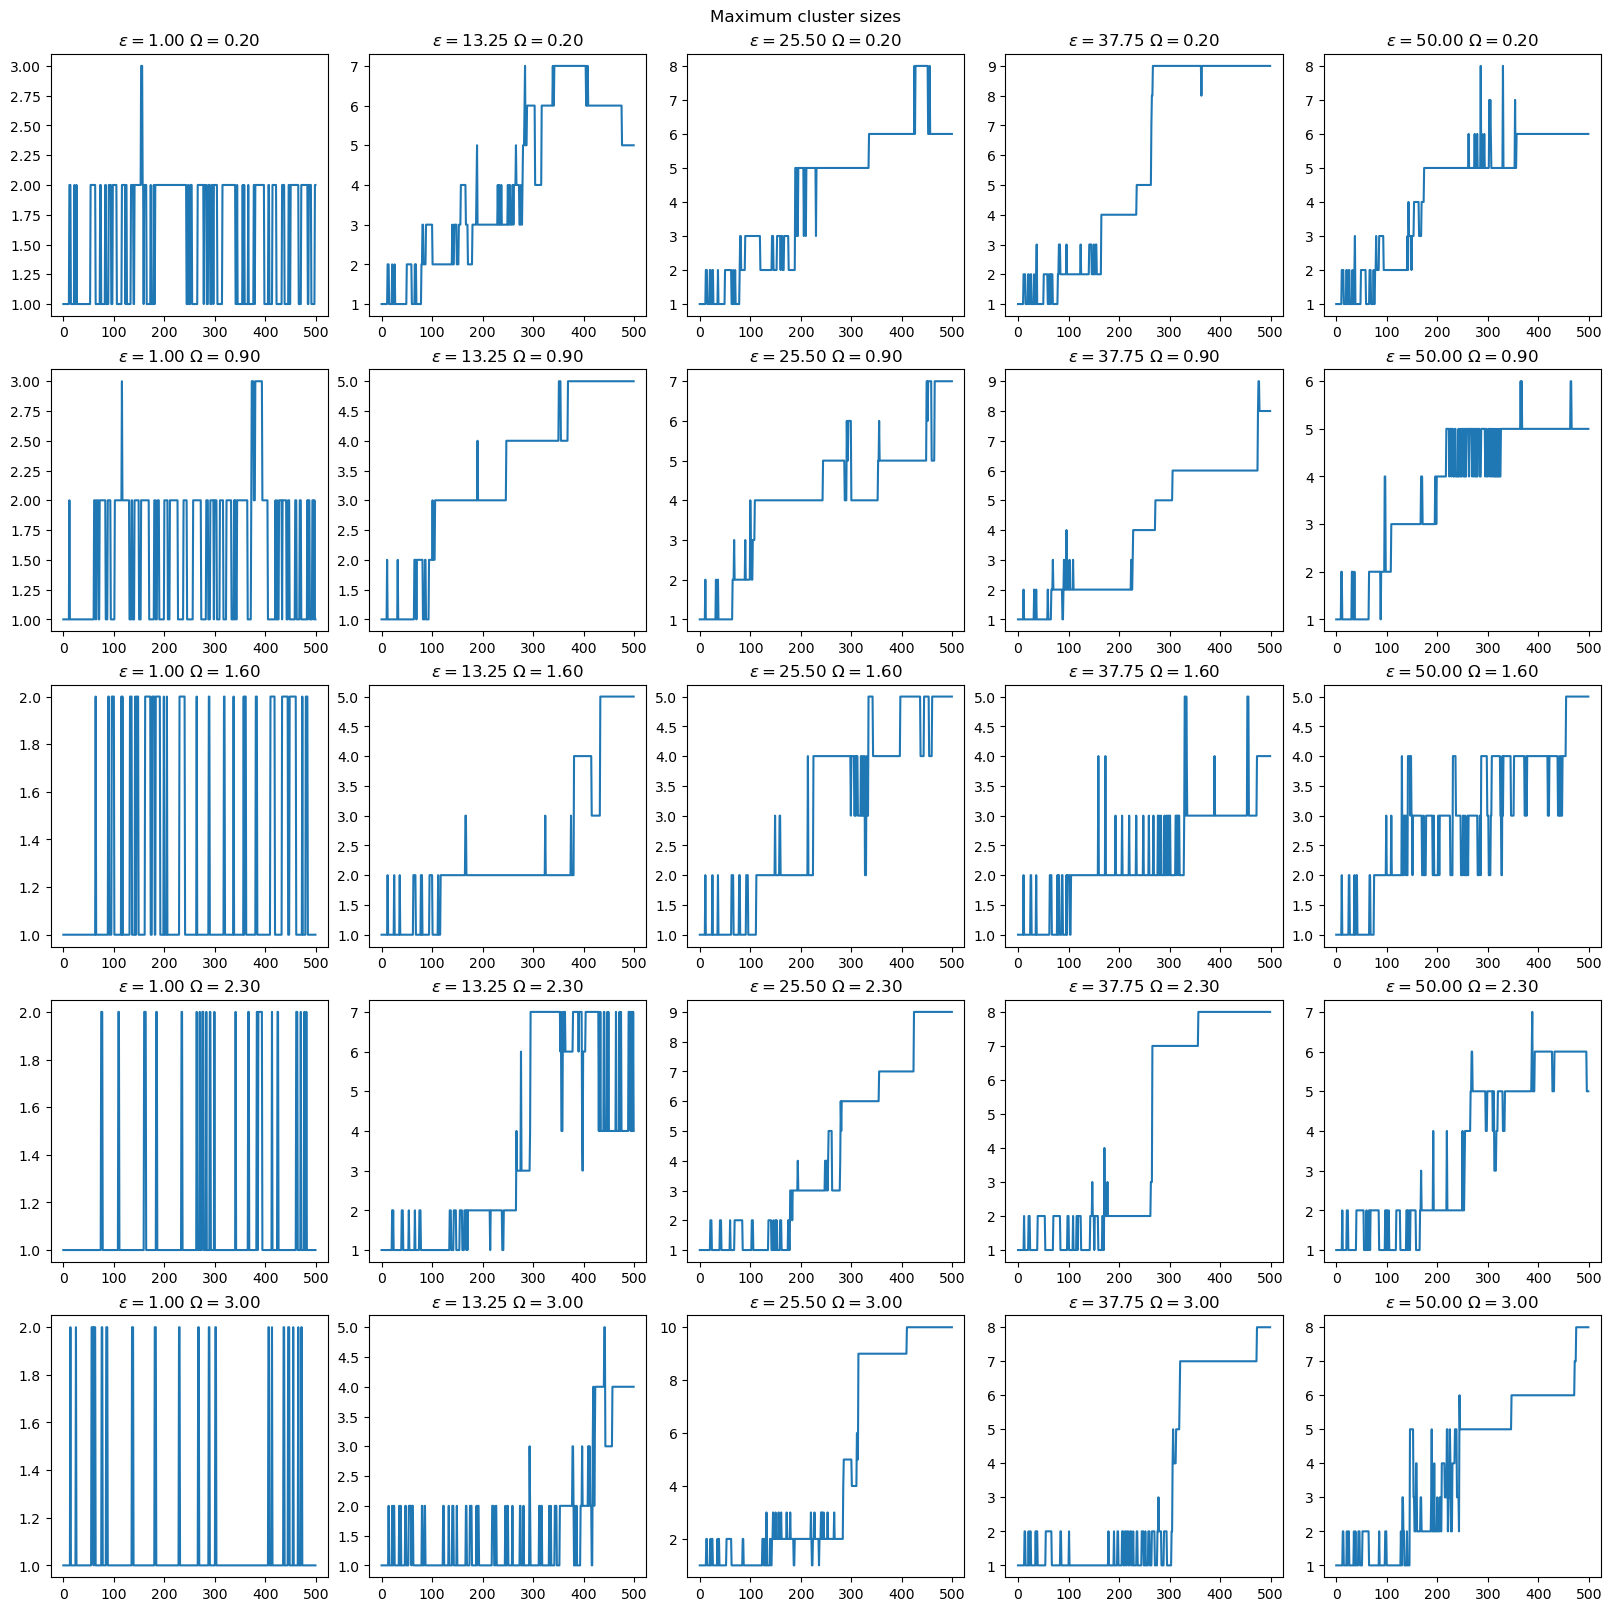

In [54]:
fig, axs = plt.subplots(5, 5, figsize = (16,16), layout = 'constrained')
for i in range(5):
    for j in range(5):
        times, Rs, ps = load_output(f"{o[i,j]:.2f}o_{e[i,j]:.2f}e.txt")
        sizes = get_max_cluster_size(Rs)
        print(f'done for omega {o[i,j]:.2f} epsilon {e[i,j]:.2f}')
        #axs[i, j].plot(t[::10], sizes_eo[i, j])
        axs[i, j].plot(times[::10], sizes)
        #moving_avg = np.convolve(sizes_eo[i, j], np.ones(window_size)/window_size, mode='same')
        #axs[i, j].plot(t[::10], moving_avg)
    #if i//5 != 0:
        #axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
        title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'f'{o[i, j]:.2f}'
        axs[i, j].set_title(title)
    
fig.suptitle(r'Maximum cluster sizes')
plt.show()

In [ ]:
epsilons = np.linspace(1., 50., 5)
omegas = np.linspace(0.2, 3., 5)
e, o = np.meshgrid(epsilons, omegas)
sizes_eo = np.empty((5, 5, 50000))
for i in range(5):
    for j in range(5):
        print(i, j)
        ps, Rs, t = solver(o[i, j], e[i, j], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 500000, noise = True)
        sizes_eo[i, j] = get_av_cluster_size(Rs)

0 0
No tumbling
omega/D_R: 61.32030749211523
0 1
No tumbling
omega/D_R: 61.32030749211523


<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_9336/1757824251.py:11: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'+f'{o[i, j]:.2f}'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_9336/1757824251.py:11: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'+f'{o[i, j]:.2f}'


NameError: name 'sizes_eo' is not defined

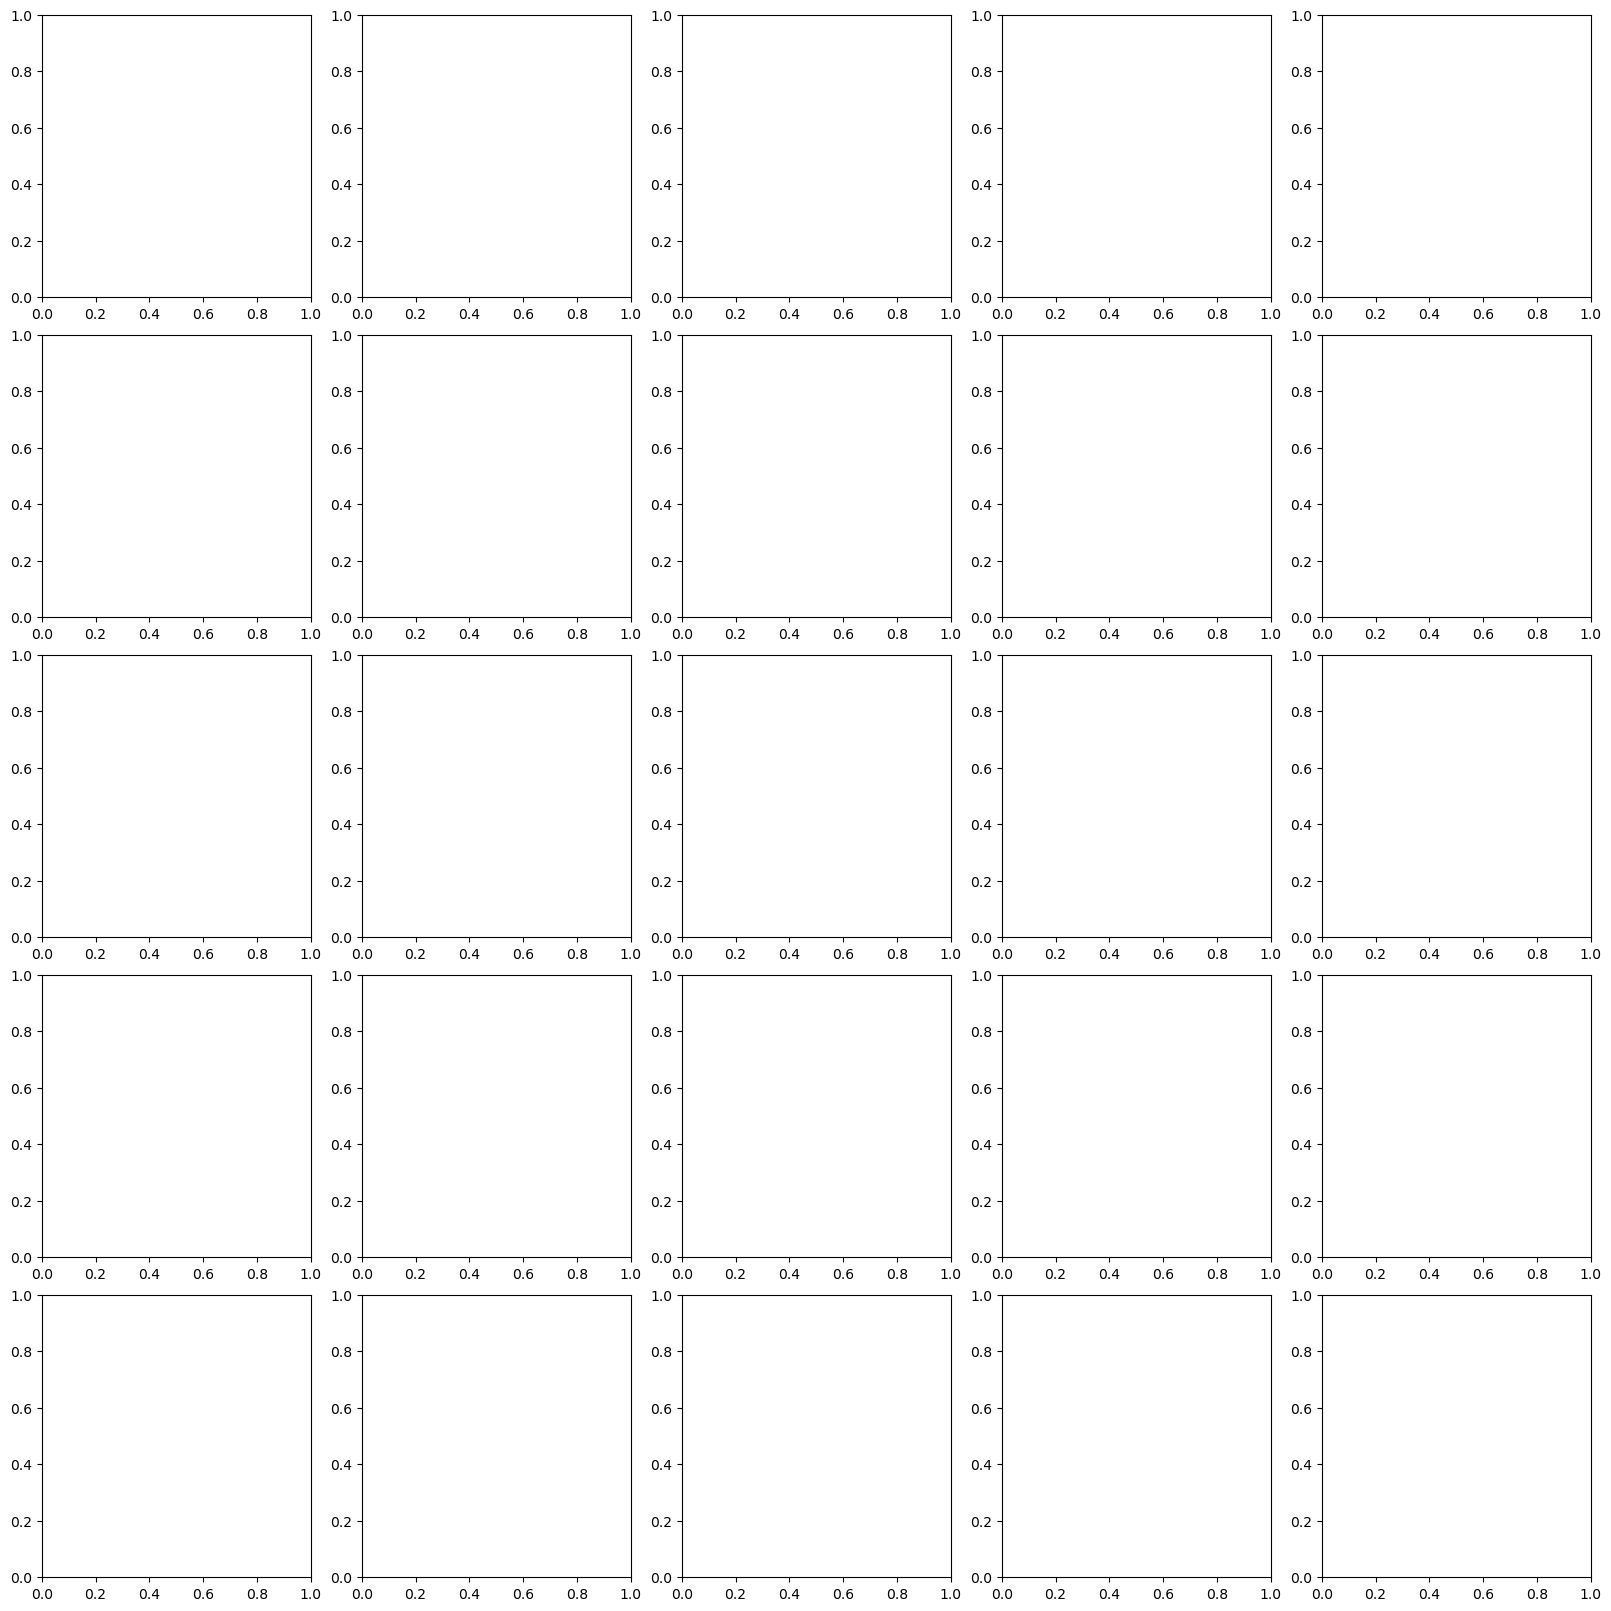

In [53]:
window_size = 20
fig, axs = plt.subplots(5, 5, figsize = (16,16), layout = 'constrained')
for i in range(5):
    for j in range(5):        
        axs[i, j].plot(t[::10], sizes_eo[i, j])
        moving_avg = np.convolve(sizes_eo[i, j], np.ones(window_size)/window_size, mode='same')
        axs[i, j].plot(t[::10], moving_avg)
    #if i//5 != 0:
        #axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
        title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'+f'{o[i, j]:.2f}'
        axs[i, j].set_title(title)
    
fig.suptitle(r'Average cluster sizes')
plt.show()

### $0<\varepsilon<100$

In [44]:
R.clear()
p.clear()
nums = []
max_sizes = []
nums.clear()
max_sizes.clear()
av_sizes.clear()
epsilons = np.linspace(1., 100., 20)
for j in range(len(epsilons)):
    print(j)
    ps, Rs, t = solver(3, epsilons[j], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    clust_num = 0
    clust_size = 0
    clust_av_size = 0
    for i in range(0, 100, 10):
        clust = np.sort(fclusterdata(Rs[ -1 - i, :, :], t=3, criterion='distance'))
        clust_num += clust[-1]
        clust_size += max_repetitions(clust)
        clust_av_size += average_size(clust)
    clust_av_size = clust_av_size / len(epsilons)
    clust_num = clust_num // len(epsilons)
    clust_size = clust_size // len(epsilons)
    nums.append(clust_num)
    max_sizes.append(clust_size)
    av_sizes.append(clust_av_size)

0
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
1
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
4
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
5
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
6
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
7
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
8
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
9
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
10
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
11
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
12
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
13
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
14
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
15
Tu

In [ ]:
save_output(t, Rs, ps, N, 5, custom_name="epsilon100", skip = 100, num = 100000)

IndexError: index 5000 is out of bounds for axis 0 with size 5000

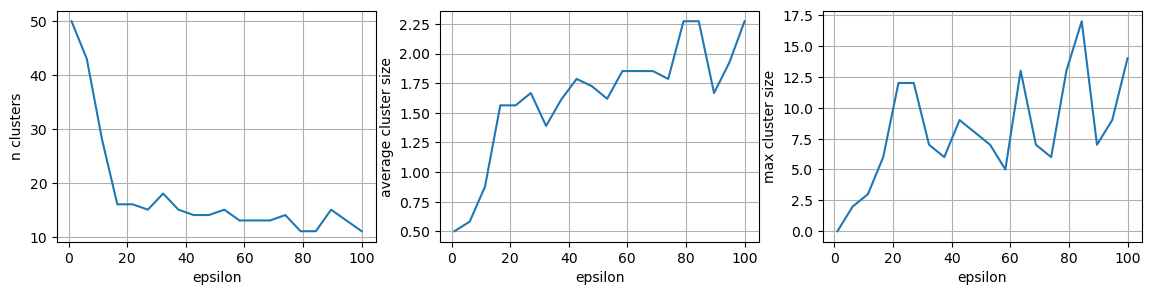

In [47]:
fig, axs = plt.subplots(1, 3, figsize = (14,3))
axs[0].plot(epsilons, nums)
axs[2].plot(epsilons, max_sizes)
axs[1].plot(epsilons, av_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[2].set_ylabel('max cluster size')
axs[1].set_ylabel('average cluster size')
axs[2].set_xlabel('epsilon')
axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.show()

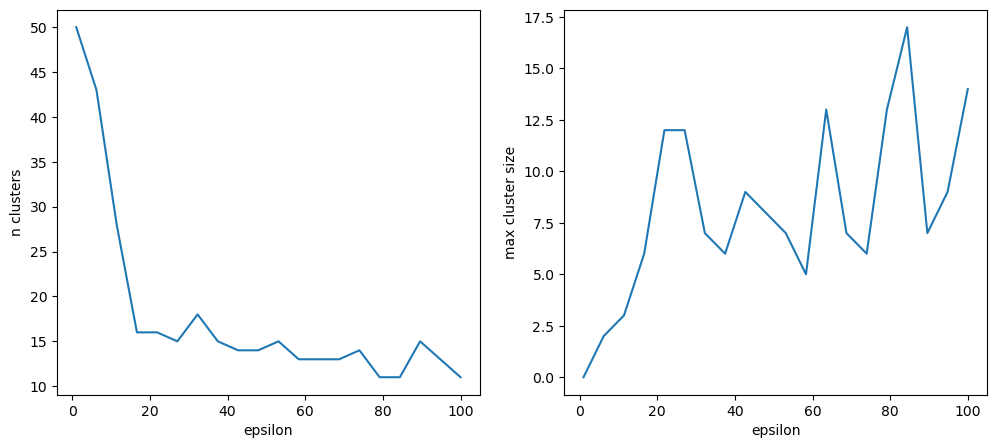

In [48]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
axs[0].plot(epsilons, nums)
axs[1].plot(epsilons, max_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[1].set_ylabel('max cluster size')

plt.show()

Other run:

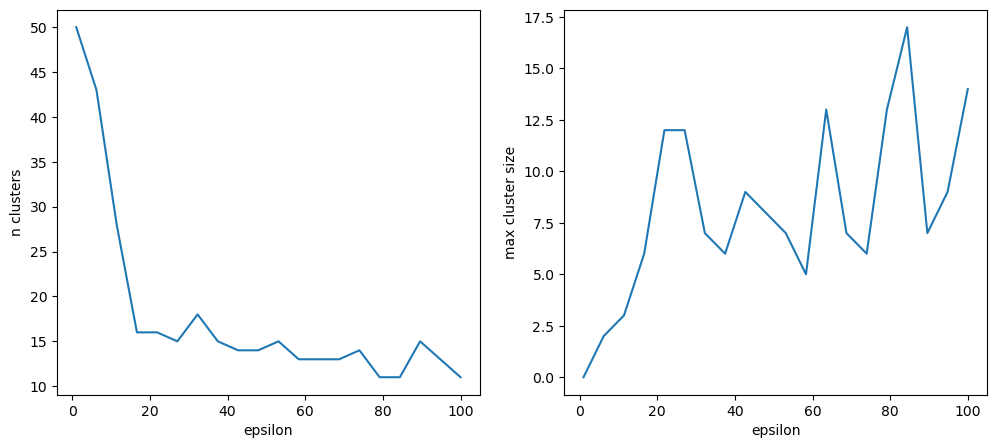

In [49]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
axs[0].plot(epsilons, nums)
axs[1].plot(epsilons, max_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[1].set_ylabel('max cluster size')

plt.show()

## Seeds averaging

In [39]:
kx = np.array([1, 0, 0]) # up vector
k0 = np.array([0, 0, 0]) 

def generate_start(N=100):
    zs = np.random.uniform(0, L, N)
    psis = np.random.uniform(0, 2*np.pi, N)
    Rs = np.random.triangular(R1 + R, R2 - R, R2 - R, N)
    vecs = np.random.normal(size = (N, 3))
    R0s = []
    p0s = []
    for i in range(N):
        R0s.append([Rs[i] * np.cos(psis[i]), Rs[i] * np.sin(psis[i]), zs[i]])
        p0s.append(vecs[i]/np.linalg.norm(vecs[i]))
    return p0s, R0s

In [42]:
epsilon = 25
omega = 1

#sizes_eo = np.empty((5, 5, 10000))
for i in range(10):
    print(i)
    p0s, R0s = generate_start()
    ps, Rs, t = solver(omega, epsilon, k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 200000, noise = True)
    save_output(t, Rs, ps, N, omega, custom_name = f"{omega:.1f}o_{epsilon}e/id{i}_long", num=200000)


0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
2
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
3
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
4
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
5
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
6
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
7
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
8
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


  0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/185031110.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


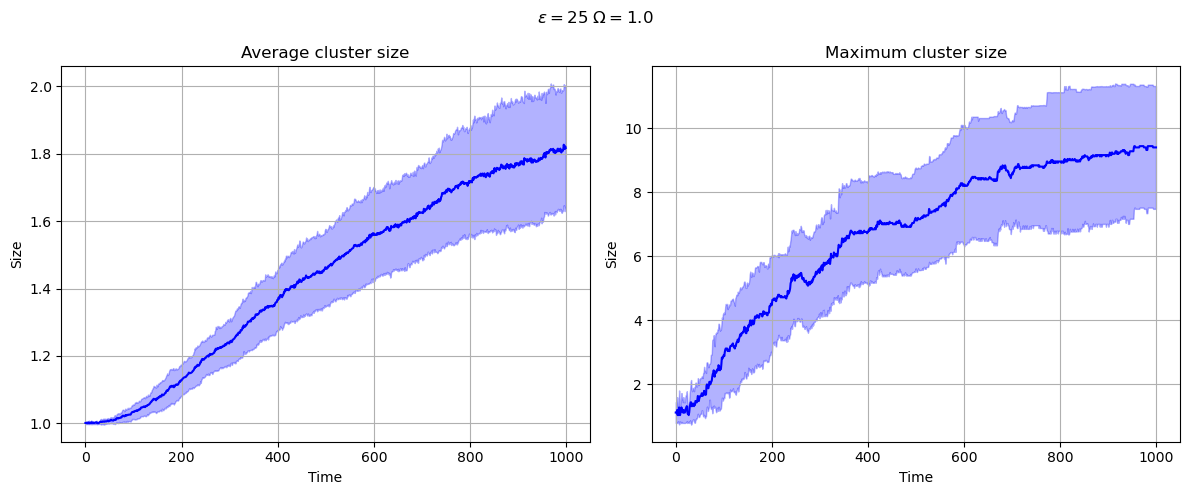

In [57]:
epsilon = 25
omega = 1

plot_seeds_average(epsilon, omega)

<>:30: SyntaxWarning: invalid escape sequence '\O'
<>:30: SyntaxWarning: invalid escape sequence '\O'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/1404083042.py:30: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{epsilon} $\Omega = $'f'{omega:.1f}'


done for id0
done for id1
done for id2
done for id3
done for id4
done for id5
done for id6
done for id7
done for id8
done for id9


/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/1404083042.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


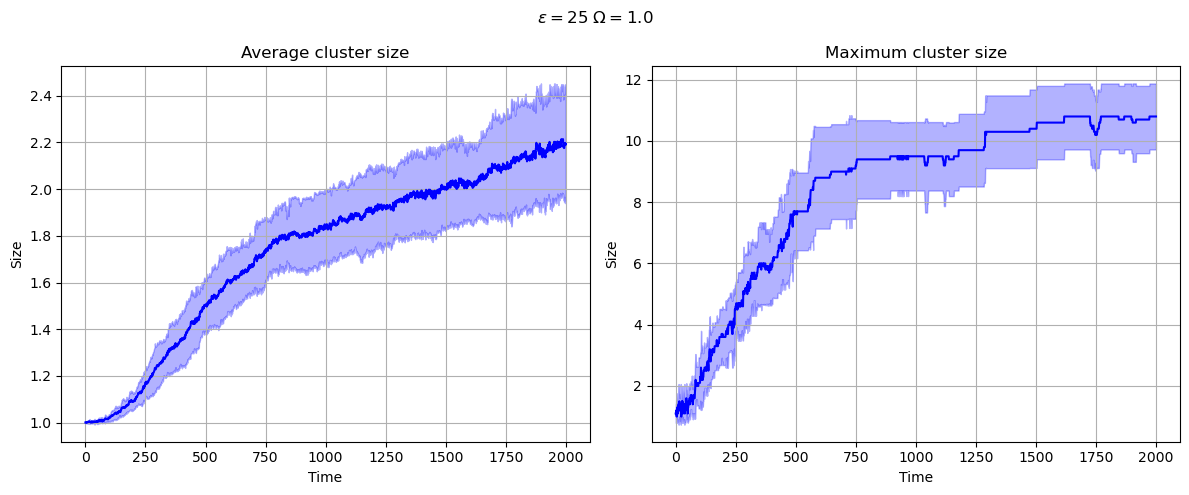

In [43]:
fig, axs = plt.subplots(1, 2, figsize = (12,5), layout = 'constrained')
av_sizes = []
max_sizes = []
for i in range(10):
    times, Rs, ps = load_output(f"{omega:.1f}o_{epsilon}e/id{i}_long.txt")
    av_sizes.append(get_av_cluster_size(Rs))
    max_sizes.append(get_max_cluster_size(Rs))
    print(f'done for id{i}')
av_sizes = np.array(av_sizes)
max_sizes = np.array(max_sizes)
av_mean = np.mean(av_sizes, axis=0)
av_std = np.std(av_sizes, axis=0)
max_mean = np.mean(max_sizes, axis=0)
max_std = np.std(max_sizes, axis=0)

axs[0].plot(times[::10], av_mean, linestyle='-', color='blue')
axs[0].fill_between(times[::10], av_mean - av_std, av_mean + av_std, alpha=0.3, color='blue', label='±1σ')
axs[0].set_title('Average cluster size') 
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Size')
axs[0].grid(True)
   
axs[1].plot(times[::10], max_mean, linestyle='-', color='blue')
axs[1].fill_between(times[::10], max_mean - max_std, max_mean + max_std, alpha=0.3, color='blue', label='±1σ')
axs[1].set_title('Maximum cluster size') 
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Size')
axs[1].grid(True)

title = r'$\varepsilon = $'f'{epsilon} $\Omega = $'f'{omega:.1f}'
fig.suptitle(title)

plt.tight_layout()
plt.show()

In [58]:
epsilon = 5
omega = 2.3

#sizes_eo = np.empty((5, 5, 10000))
for i in range(25):
    print(i)
    p0s, R0s = generate_start()
    ps, Rs, t = solver(omega, epsilon, k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    save_output(t, Rs, ps, N, omega, custom_name = f"{omega:.1f}o_{epsilon}e/id{i}", num=100000)


0
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
1
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
2
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
3
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
4
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
5
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
6
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
7
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
8
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
9
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
10
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
11
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
12
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
13
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
14
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
15
Tu

  0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/185031110.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


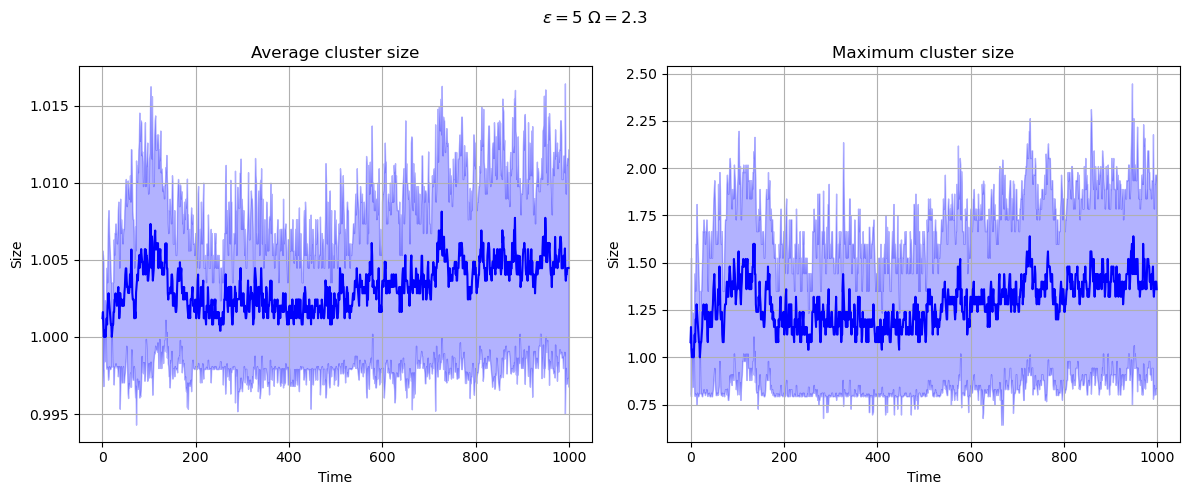

In [59]:
plot_seeds_average(omega=2.3, epsilon=5)

  0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/185031110.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


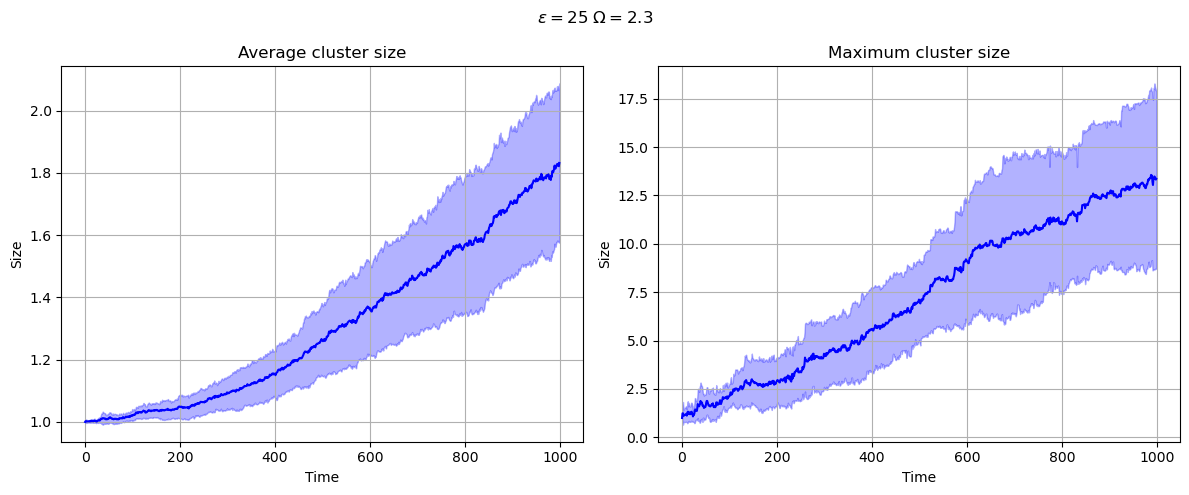

In [55]:
plot_seeds_average(omega=2.3, epsilon=25)

  0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/185031110.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


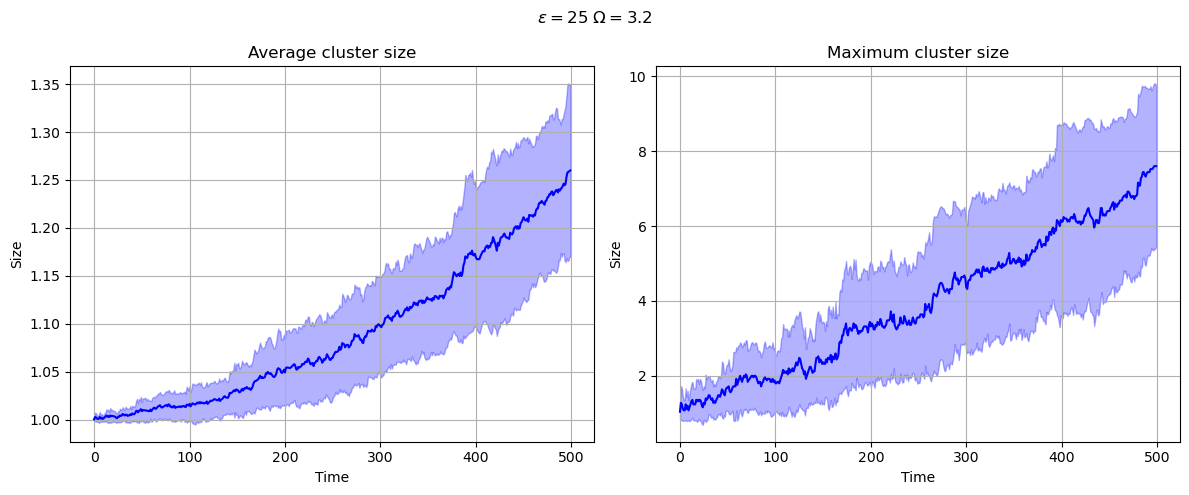

In [56]:
plot_seeds_average(omega=3.2, epsilon=25)

In [54]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

  0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/185031110.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


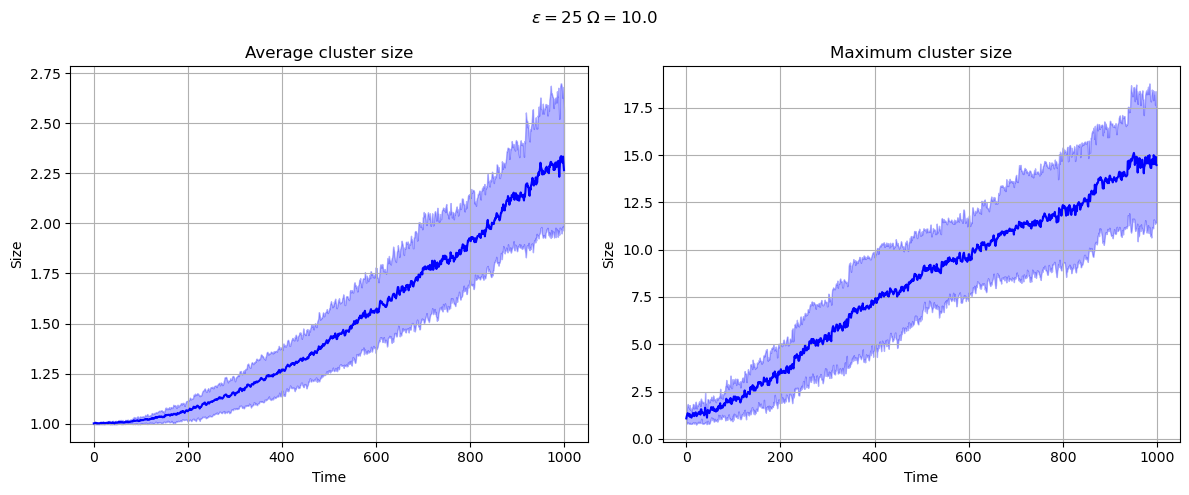

In [53]:
plot_seeds_average(omega=10, epsilon=25)

<>:44: SyntaxWarning: invalid escape sequence '\O'
<>:44: SyntaxWarning: invalid escape sequence '\O'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/2749900741.py:44: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{epsilon} $\Omega = $'f'{omega:.1f}'


  0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_16512/2749900741.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


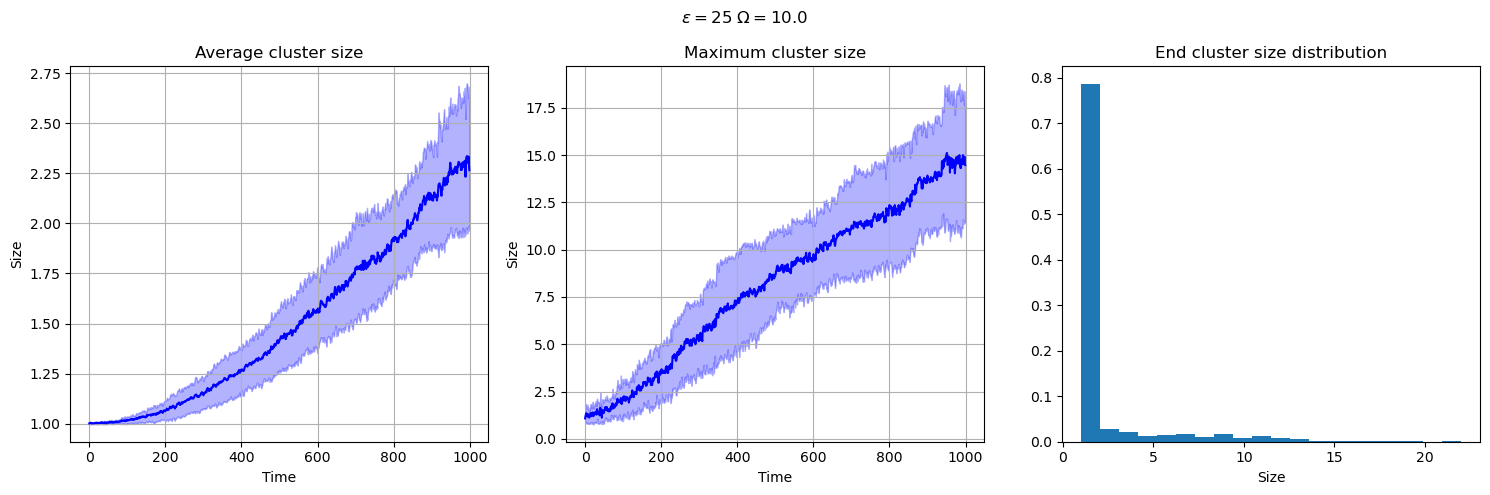

In [107]:
N=25
omega = 10
epsilon = 25


fig, axs = plt.subplots(1, 3, figsize = (15,5), layout = 'constrained')
av_sizes = []
max_sizes = []
end_sizes = []
for i in tqdm(range(N)):
    times, Rs, ps = load_output(f"{omega:.1f}o_{epsilon}e/id{i}.txt")
    av_sizes.append(get_av_cluster_size(Rs))
    max_sizes.append(get_max_cluster_size(Rs))
    end_sizes.append(get_size_distribution(Rs[-1,:,:]))
    
    #print(f'done for id{i}')
av_sizes = np.array(av_sizes)
max_sizes = np.array(max_sizes)
av_mean = np.mean(av_sizes, axis=0)
av_std = np.std(av_sizes, axis=0)
max_mean = np.mean(max_sizes, axis=0)
max_std = np.std(max_sizes, axis=0)
end_sizes = np.concatenate([np.array(sub) for sub in end_sizes])

axs[0].plot(times[::10], av_mean, linestyle='-', color='blue')
axs[0].fill_between(times[::10], av_mean - av_std, av_mean + av_std, alpha=0.3, color='blue', label='±1σ')
axs[0].set_title('Average cluster size') 
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Size')
axs[0].grid(True)

axs[1].plot(times[::10], max_mean, linestyle='-', color='blue')
axs[1].fill_between(times[::10], max_mean - max_std, max_mean + max_std, alpha=0.3, color='blue', label='±1σ')
axs[1].set_title('Maximum cluster size') 
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Size')
axs[1].grid(True)

axs[2].hist(end_sizes, density=True, bins=20)
#axs[1].fill_between(times[::10], max_mean - max_std, max_mean + max_std, alpha=0.3, color='blue', label='±1σ')
axs[2].set_title('End cluster size distribution') 
axs[2].set_xlabel('Size')

title = r'$\varepsilon = $'f'{epsilon} $\Omega = $'f'{omega:.1f}'
fig.suptitle(title)

plt.tight_layout()
plt.show()

In [105]:
end_sizes.flatten

<function ndarray.flatten>

## End states


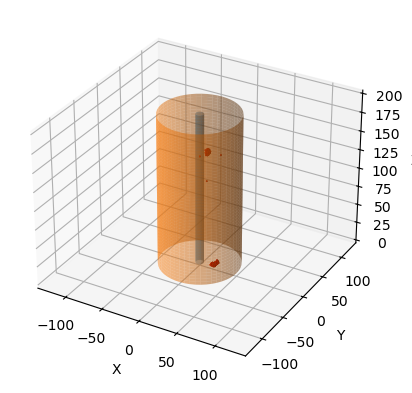

In [82]:
times, Rs, ps = load_output("epsilon50_long.txt")
plot_state(Rs[-1, :, :])

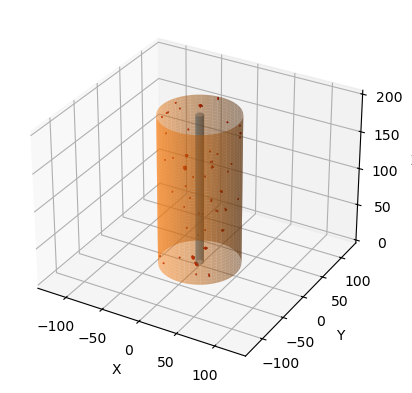

In [84]:
times, Rs, ps = load_output("3.00o_50.00e.txt")
plot_state(Rs[-1, :, :])

## ?

/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_77527/1219468392.py:33: RuntimeWarning: divide by zero encountered in divide
  pg.transpose(), rg.transpose(), (xp/rg).transpose(), xr.transpose(),
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_77527/1219468392.py:33: RuntimeWarning: invalid value encountered in divide
  pg.transpose(), rg.transpose(), (xp/rg).transpose(), xr.transpose(),
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_77527/1219468392.py:36: RuntimeWarning: divide by zero encountered in divide
  pg.transpose(), rg.transpose(), (yp/rg).transpose(), yr.transpose(),


(0.0, 1.0)

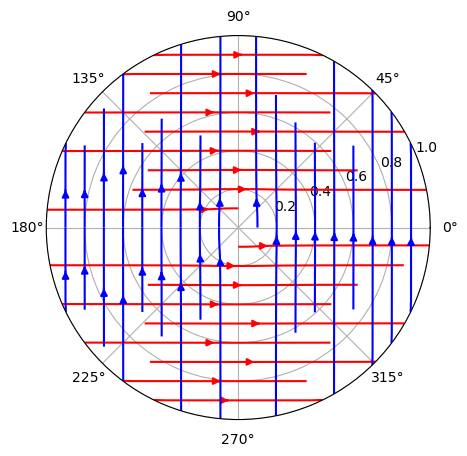

In [199]:
import math
plt.gcf().add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

# coordinates
r = np.linspace(0, 1, 11)
p = np.linspace(-math.pi, math.pi, 361)
rg, pg = np.meshgrid(r, p)

def repeat(x):
  return np.full_like(r, x)

epsilon = 1e-8

# cylindrical components of horizontal unit vector
xr =  np.cos(pg)
xp = -np.sin(pg)
# cylindrical components of vertical unit vector
yr =  np.sin(pg)
yp =  np.cos(pg)

# starting points of streamlines
sx = np.transpose([
  np.hstack([repeat(-math.pi/2), repeat(math.pi/2)]),
  np.hstack([r, r])
])
sy = np.transpose([
  np.hstack([repeat(-math.pi+epsilon), repeat(0), repeat(math.pi-epsilon)]),
  np.hstack([r, r, r])
])

# streamlines
plt.streamplot(
  pg.transpose(), rg.transpose(), (xp/rg).transpose(), xr.transpose(),
  color='red', start_points=sx)
plt.streamplot(
  pg.transpose(), rg.transpose(), (yp/rg).transpose(), yr.transpose(),
  color='blue', start_points=sy)

plt.ylim(0, 1)


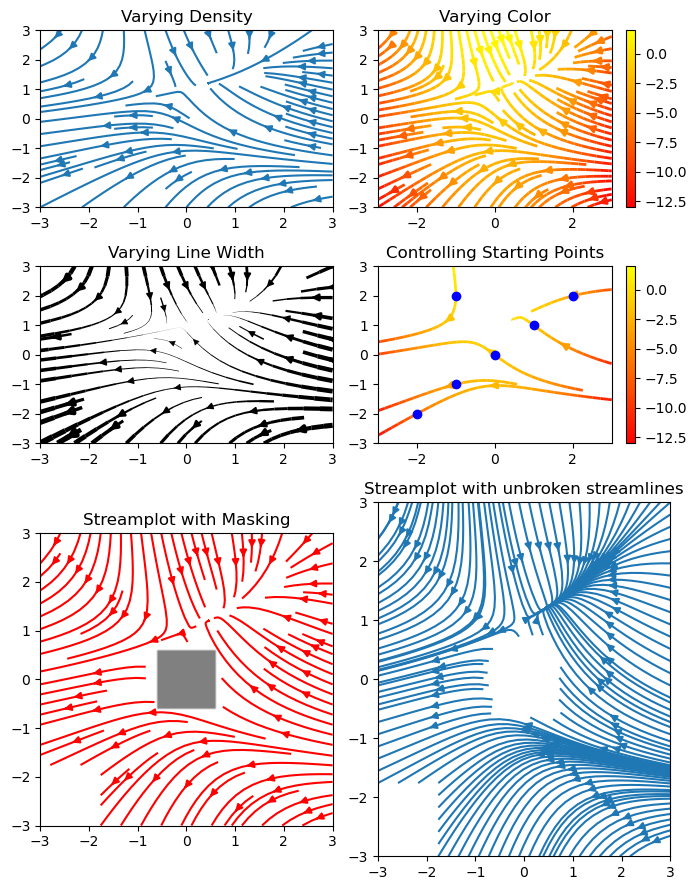

In [200]:
import matplotlib.pyplot as plt
import numpy as np

w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

fig, axs = plt.subplots(3, 2, figsize=(7, 9), height_ratios=[1, 1, 2])
axs = axs.flat

#  Varying density along a streamline
axs[0].streamplot(X, Y, U, V, density=[0.5, 1])
axs[0].set_title('Varying Density')

# Varying color along a streamline
strm = axs[1].streamplot(X, Y, U, V, color=U, linewidth=2, cmap='autumn')
fig.colorbar(strm.lines)
axs[1].set_title('Varying Color')

#  Varying line width along a streamline
lw = 5*speed / speed.max()
axs[2].streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw)
axs[2].set_title('Varying Line Width')

# Controlling the starting points of the streamlines
seed_points = np.array([[-2, -1, 0, 1, 2, -1], [-2, -1,  0, 1, 2, 2]])

strm = axs[3].streamplot(X, Y, U, V, color=U, linewidth=2,
                         cmap='autumn', start_points=seed_points.T)
fig.colorbar(strm.lines)
axs[3].set_title('Controlling Starting Points')

# Displaying the starting points with blue symbols.
axs[3].plot(seed_points[0], seed_points[1], 'bo')
axs[3].set(xlim=(-w, w), ylim=(-w, w))

# Create a mask
mask = np.zeros(U.shape, dtype=bool)
mask[40:60, 40:60] = True
U[:20, :20] = np.nan
U = np.ma.array(U, mask=mask)

axs[4].streamplot(X, Y, U, V, color='r')
axs[4].set_title('Streamplot with Masking')

axs[4].imshow(~mask, extent=(-w, w, -w, w), alpha=0.5, cmap='gray',
              aspect='auto')
axs[4].set_aspect('equal')

axs[5].streamplot(X, Y, U, V, broken_streamlines=False)
axs[5].set_title('Streamplot with unbroken streamlines')

plt.tight_layout()
plt.show()